In [1]:
#Various dependencies for the scripts belowco
from pylab import *
import scipy
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import manifold
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.image as mpimg
import pandas as pd
from collections import Counter
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr
from scipy.signal import correlate
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from scipy import optimize
from numpy import log10
from sklearn import linear_model
from sklearn import preprocessing
from math import *
from random import shuffle
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 , 'white'),(1, 'red')])
import networkx
import matplotlib
#from mpl_toolkits.axes_grid1 import AxesGrid


def running_mean(x, N):
    vec = 0
    for i in range(len(x)):
        cumsum = np.cumsum(np.insert(x[i], 0, 0)) 
        new = (cumsum[N:] - cumsum[:-N]) / float(N)
        if isinstance(vec, int):
            vec = new
        else:
            vec = np.vstack((vec,new))
    return vec


def normalize(x):
    row_mean = x.mean(axis=1)
    new = x.astype(float)/ row_mean[:,None].astype(float)
    return new

def smooth_vec(a):
    plot_smooth = pd.DataFrame(np.nan_to_num(normalize(a)))
    rolling_smooth = np.nan_to_num(plot_smooth.rolling(window=25,center=True,axis=1).mean().values) 
    return rolling_smooth

def norm(a):
    a_prime = np.copy(a)
#   a_prime[a_prime > 0] = 1
    a_prime = (a_prime - np.mean(a_prime)) / (np.std(a_prime) * len(a_prime))
    return a_prime


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.serif'] = ['Arial']
rcParams["font.size"] = "50"

#func taken from Stack Overflow credit: SO user Paul H
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

IOError: [Errno 2] No such file or directory: '/Users/vramani/Dropbox/FigS1.pdf'

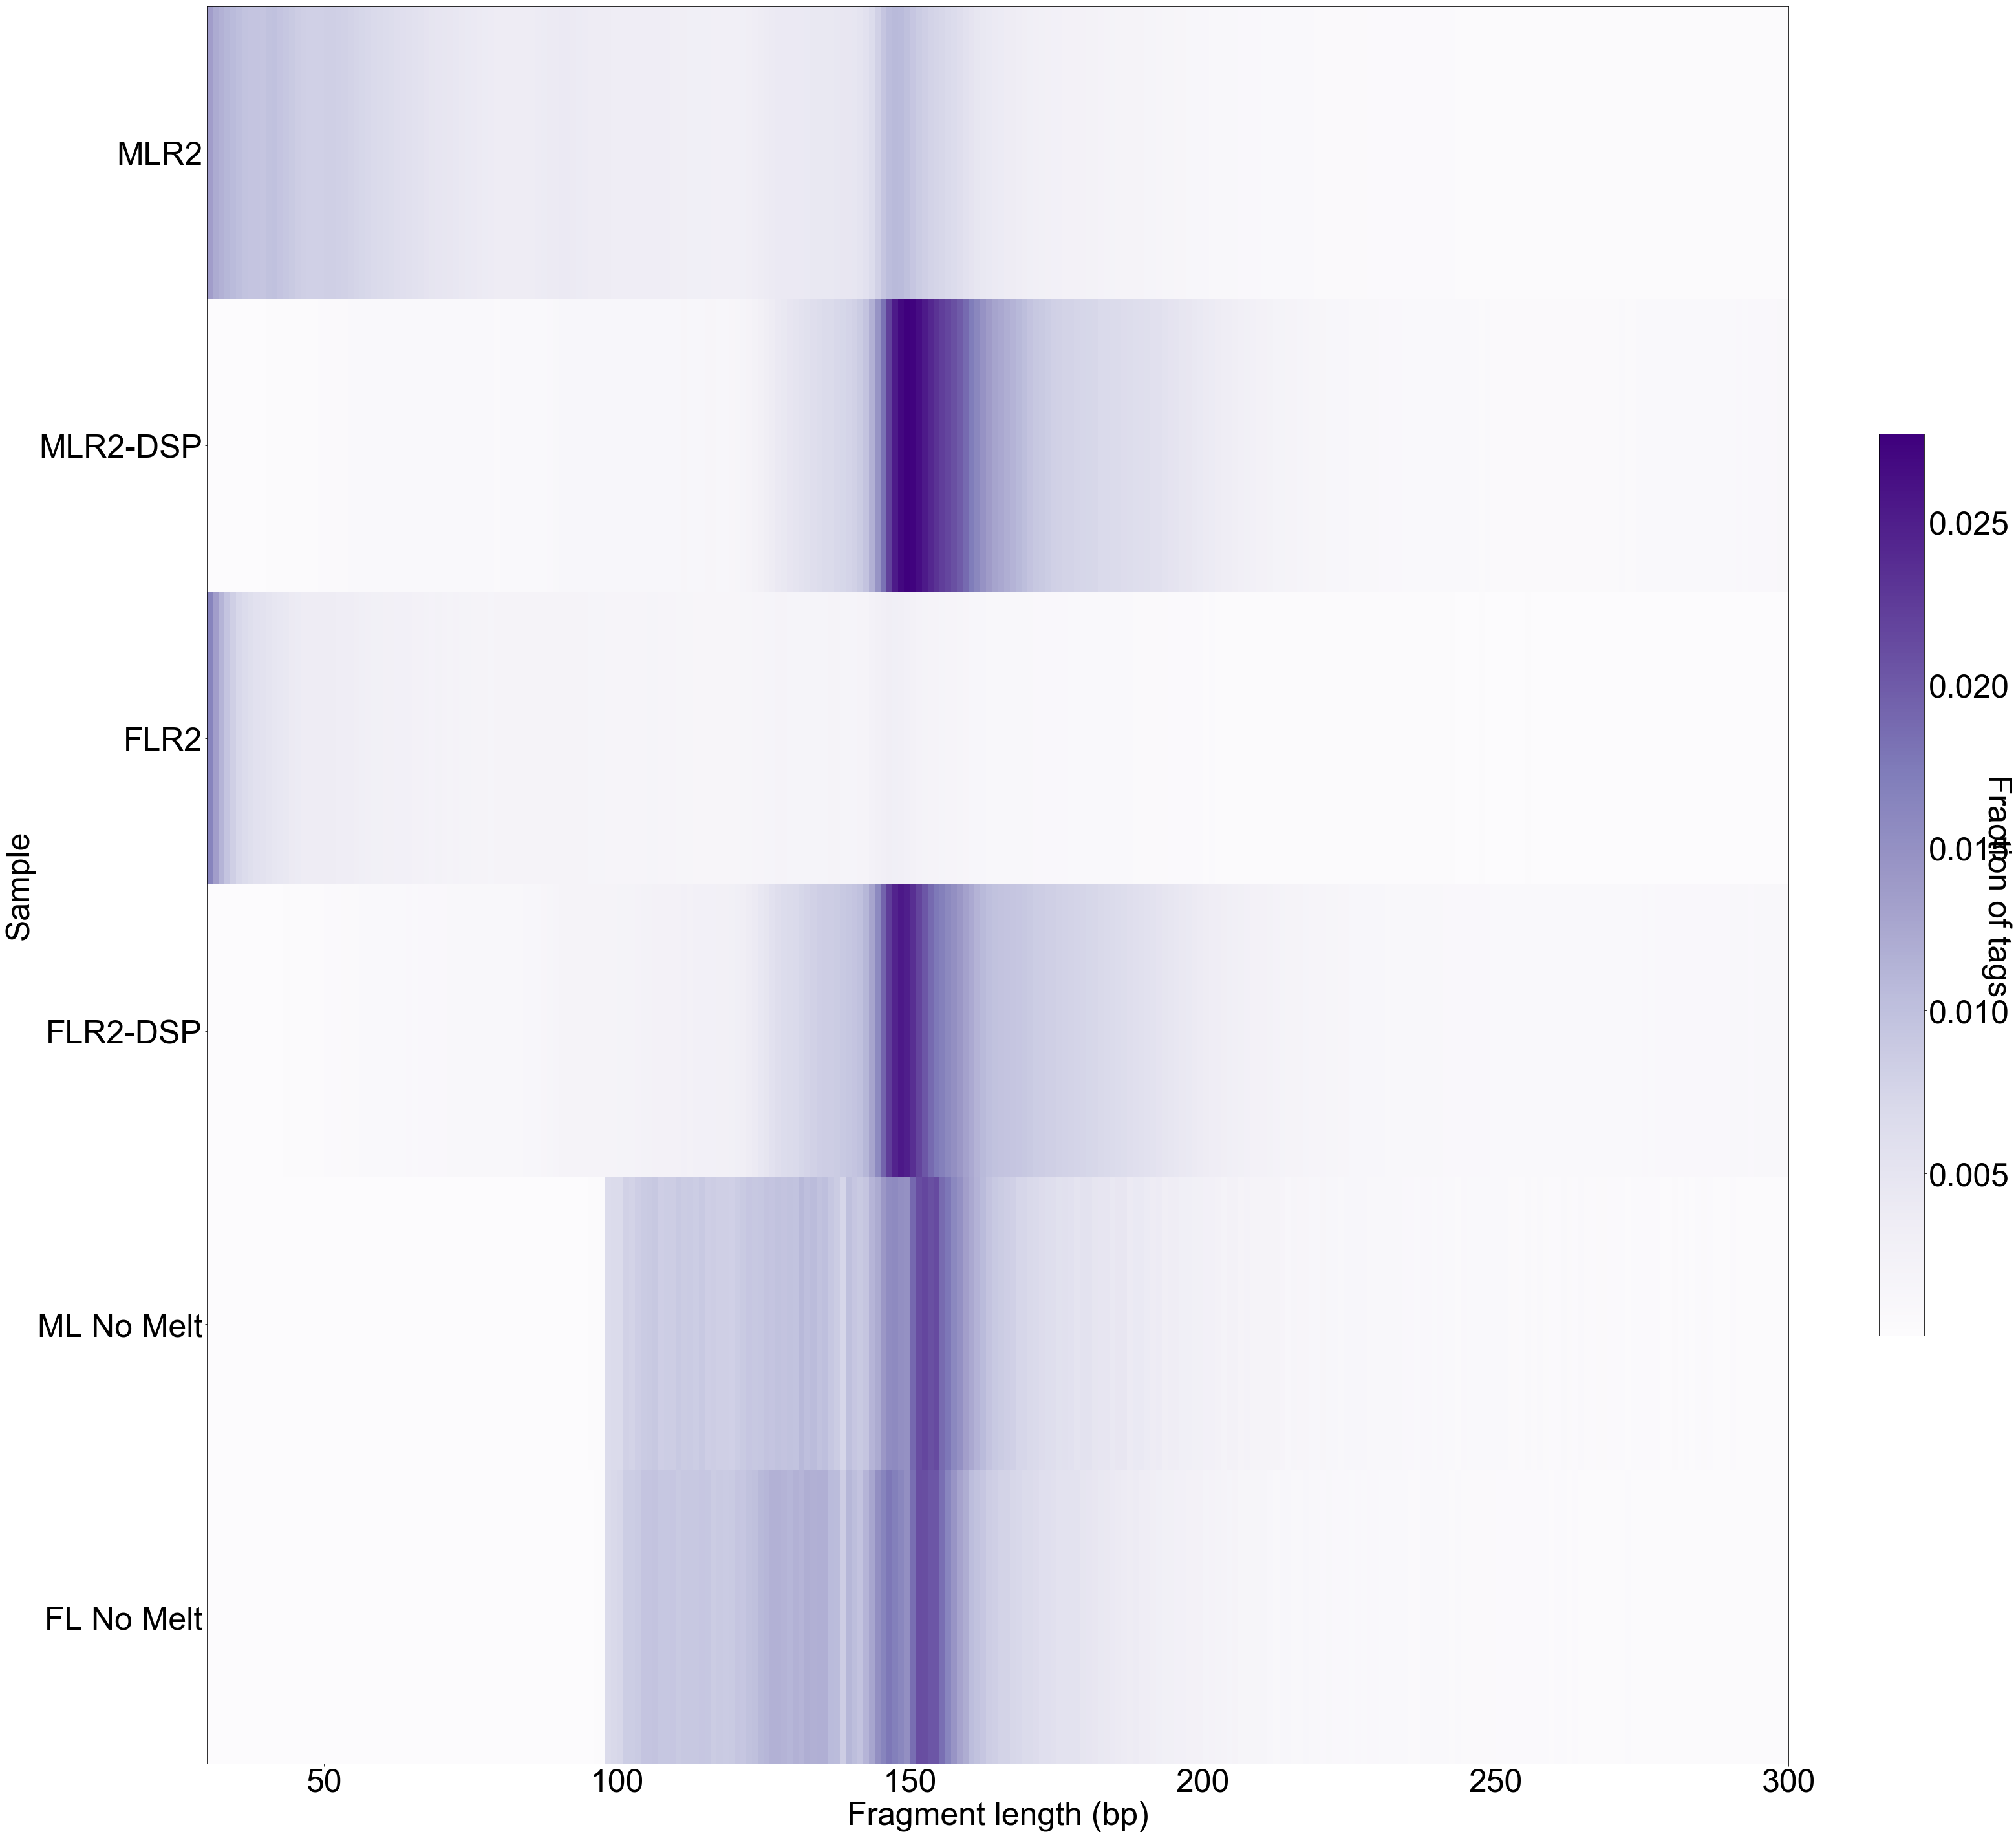

In [2]:
#This is code to generate panels for MNase-SSP Figure 1. This code takes .npy format arrays
#and generates the desired heatmaps. Code for Fig. 1C is provided in the GitHub repo, and was plotted
#using ggplot.

#Fig 1B AND FIGS1
male_ssp = open("Male.mm10.sorted.deduped.bam.lengths")
male_ssp_2 = open("1min_MNase.mm10.sorted.deduped.bam.length_distro")
female_ssp = open("Female.mm10.sorted.deduped.bam.lengths")
female_ssp2 = open("female_ssp_rep2.length")
male_dsp = open("Male_DSP_rep1.deduped.sorted.bam.length")
female_dsp = open("Female_DSP_rep1.deduped.sorted.bam.length")
male_dsp_2 = open("Male_DSP_rep2.deduped.sorted.bam.length")
female_dsp_2 = open("Female_DSP_rep2.deduped.sorted.bam.length")
male_ssp_nomelt = open("Male_nomelt.length")
female_ssp_nomelt = open("Female_nomelt.length")
#rando = open("/net/shendure/vol8/projects/single.cell.combinatorics/nobackup/sslib_mESC_deepseq/Rando.mm10.sorted.deduped.bam.lengths")
#atac = open("/net/shendure/vol8/projects/single.cell.combinatorics/nobackup/sslib_mESC_deepseq/Chang.mm10.sorted.deduped.bam.lengths")

#fhis = [male_ssp_2, female_ssp, male_dsp, male_dsp_2, rando, atac]
fhis = [male_dsp_2, female_ssp2, female_dsp_2, male_ssp_nomelt, female_ssp_nomelt]
labels = ["MLR2", "MLR2-DSP","FLR2", "FLR2-DSP", "ML No Melt", "FL No Melt"]

matrix = vectorize_lengths(male_ssp_2)
male_ssp.close()

for i in fhis:
    matrix = np.vstack((matrix, vectorize_lengths(i)))
    i.close()
num_samp = len(matrix)

ggformat = open("FLD_FIGS1.ggplot.txt", 'w')
for i in range(len(matrix)):
    label = labels[i]
    for j in range(len(matrix[i])):
        print >> ggformat, "%s\t%s\t%s" % (label, j + 30, matrix[i][j])  

ggformat.close()

plt.figure(figsize=(50,50))    
imshow(matrix, interpolation="none",cmap=cm.Purples, aspect=float(150)/float(num_samp) * 2, extent=[30,300,0,num_samp])
colorbar(fraction=0.025).set_label('Fraction of tags', rotation=270)
plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
ax.set_ylabel("Sample", fontname="Arial", fontsize=50)
ax.set_xlabel("Fragment length (bp)")
plt.savefig("/Users/vramani/Dropbox/FigS1.pdf")
plt.show()

male_ssp = open("Male.mm10.sorted.deduped.bam.lengths")
male_ssp_2 = open("Female.mm10.sorted.deduped.bam.lengths")
male_dsp = open("Male_DSP_rep1.deduped.sorted.bam.length")
male_dsp_2 = open("Female_DSP_rep1.deduped.sorted.bam.length")
rando = open("Rando.mm10.sorted.deduped.bam.lengths")
krep1 = open("Kadonaga_low_rep1.length.hist")
krep2 = open("Kadonaga_low_rep2.length.hist")
#fhis = [male_ssp_2, female_ssp, male_dsp, male_dsp_2, rando, atac]
fhis = [male_ssp_2, male_dsp, male_dsp_2, rando, krep1, krep2]
labels = ["ML","FL", "ML-DSP","FL-DSP", "Carone et al", "Ishii et al", "Ishii et al R2"]

matrix = vectorize_lengths(male_ssp)
male_ssp.close()

for i in fhis:
    matrix = np.vstack((matrix, vectorize_lengths(i)))
    i.close()
num_samp = len(matrix)

ggformat = open("FLD_FIG1.ggplot.txt", 'w')
for i in range(len(matrix)):
    label = labels[i]
    for j in range(len(matrix[i])):
        print >> ggformat, "%s\t%s\t%s" % (label, j + 30, matrix[i][j])  

ggformat.close()

plt.figure(figsize=(25,25))    
imshow(matrix, interpolation="none",cmap=cm.Purples, aspect=float(150)/float(num_samp) * 2, extent=[30,300,0,num_samp])
colorbar(fraction=0.025).set_label('Fraction of tags', rotation=270)
plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
ax.set_ylabel("Sample", fontname="Arial", fontsize=50)
ax.set_xlabel("Fragment length (bp)")
plt.savefig("/Users/vramani/Dropbox/Fig1B.pdf")
plt.show()

#END FIG1B

# #FIG1C Rscript
# MALE_f <- read.table("~/Dropbox/MALE_right_2mer_f.tsv")
# MALE_r <- read.table("~/Dropbox/MALE_left_2mer_f.tsv")
# MALE2_f <- read.table("~/Dropbox/1min_MNase_right_2mer_f.tsv")
# MALE2_r <- read.table("~/Dropbox/1min_MNase_left_2mer_f.tsv")
# MALE_DSP_f <- read.table("~/Dropbox/Male_DSP_rep1_right_2mer_f.tsv")
# MALE_DSP_r <- read.table("~/Dropbox/Male_DSP_rep1_left_2mer_f.tsv")
# MALE2_DSP_f <- read.table("~/Dropbox/Male_DSP_rep2_right_2mer_f.tsv")
# MALE2_DSP_r <- read.table("~/Dropbox/Male_DSP_rep2_left_2mer_f.tsv")
# RANDO_f <- read.table("~/Dropbox/RANDO_right_2mer_f.tsv")
# RANDO_r <- read.table("~/Dropbox/RANDO_left_2mer_f.tsv")
# KADONAGA_f <- read.table("~/Dropbox/KADONAGA_REP1_right_2mer_f.tsv")
# KADONAGA_r <- read.table("~/Dropbox/KADONAGA_REP1_left_2mer_f.tsv")

# background <- read.table("~/Dropbox/mm10.2mers.tsv")
# bfreq <- (background$V2 / sum(as.numeric(background$V2)))

# Male_flog <- (MALE_f$V2 / sum(as.numeric(MALE_f$V2))) / bfreq
# Male_rlog <- (MALE_r$V2 / sum(as.numeric(MALE_r$V2))) / bfreq

# Male2_flog <- (MALE2_f$V2 / sum(as.numeric(MALE2_f$V2))) / bfreq
# Male2_rlog <- (MALE2_r$V2 / sum(as.numeric(MALE2_r$V2))) / bfreq

# MaleD_flog <- (MALE_DSP_f$V2 / sum(as.numeric(MALE_DSP_f$V2))) / bfreq
# MaleD_rlog <- (MALE_DSP_r$V2 / sum(as.numeric(MALE_DSP_r$V2))) / bfreq

# Male2D_flog <- (MALE2_DSP_f$V2 / sum(as.numeric(MALE2_DSP_f$V2))) / bfreq
# Male2D_rlog <- (MALE2_DSP_r$V2 / sum(as.numeric(MALE2_DSP_r$V2))) / bfreq

# Rando_flog <- RANDO_f$V2 / sum(as.numeric(RANDO_f$V2)) / bfreq
# Rando_rlog <- RANDO_r$V2 / sum(as.numeric(RANDO_r$V2)) / bfreq

# Kadonaga_flog <- KADONAGA_f$V2 / sum(as.numeric(KADONAGA_f$V2)) / bfreq
# Kadonaga_rlog <- KADONAGA_r$V2 / sum(as.numeric(KADONAGA_r$V2)) / bfreq

# dinucs=rep(as.character(MALE_f$V1), 12)
# freqs = c(Male_flog,Male_rlog,Male2_flog,Male2_rlog, MaleD_flog, MaleD_rlog, Male2D_flog, Male2D_rlog, Rando_flog, Rando_rlog, Kadonaga_flog, Kadonaga_rlog)
# logfreqs = log(freqs)
# labs = rep(c(rep("5'", length(MALE_f$V1)), rep("3'", length(MALE_r$V1))), 6)
# samps = c(rep("ML", length(MALE_f$V1)*2), rep("ML_r2", length(MALE_f$V1)*2), rep("ML-DSP", length(MALE_f$V1)*2), rep("ML_r2-DSP", length(MALE_f$V1)*2), rep("Carone et al", length(MALE_f$V1)*2), rep("Ishii et al", length(MALE_f$V1)*2))

# plotme <- data.frame(x=dinucs, y=logfreqs,labs=labs,samps=samps)
# plotme$ordered_samps <- factor(plotme$samps, c("ML", "ML_r2", "ML-DSP", "ML_r2-DSP", "Carone et al", "Ishii et al"))
# plotme$ordered <- factor(plotme$labs, c("5'", "3'"))

# ggplot(plotme, aes(x=x,y=y, fill=ordered)) + geom_bar(stat="identity") + theme_bw() + facet_grid(ordered_samps ~ ordered) + theme(legend.position="none", text=element_text(size = 20)) + scale_fill_brewer(palette = "Set1") + labs(x="Dinucleotide (5' -> 3')", y="log2(Observed / Expected)")

#FIG1D RSCRIPT
# male_bv <- read.table("~/Dropbox/Male_sums")
# male_r2_bv <- read.table("~/Dropbox/1min_sums")
# male_d_bv <- read.table("~/Dropbox/Male_DSP_rep1_sums")
# male_d2_bv <- read.table("~/Dropbox/Male_DSP_rep2_sums")
# rando <- read.table("~/Dropbox/Rando_sums")
# k_rep1 <- read.table("~/Dropbox/Krep1_sums")
# k_rep2 <- read.table("~/Dropbox/Krep2_sums")

# tot = rbind.data.frame(male_bv,male_r2_bv, male_d_bv, male_d2_bv, rando,k_rep1,k_rep2)
# labs = c(rep("ML",length(male_bv$V1)), rep("ML_r2", length(male_r2_bv$V1)), rep("ML-DSP", length(male_d_bv$V1)), rep("ML_r2-DSP", length(male_d2_bv$V1)), rep("Carone et al", length(rando$V1)), rep("Ishii et al (rep1)", length(k_rep1$V1)), rep("Ishii et al (rep2)", length(k_rep2$V1)))
# tot$lab <- labs
# tot$ordered <- factor(tot$V2, c("+", "-"))
# tot$ordered_names <- factor(tot$lab, c("ML", "ML_r2", "ML-DSP", "ML_r2-DSP", "Carone et al", "Ishii et al (rep1)", "Ishii et al (rep2)"))
# ggplot(tot,aes(x=V1,y=V3,colour=ordered_names)) + geom_point() + theme_bw() + scale_color_brewer(palette = "Set1") + facet_grid(ordered ~ .) + theme(text = element_text(size = 20)) + labs(x="Fragment length (bp)", y="Sum(ln(Oi/E)")
# ggsave("FIG1D_bias_vectors.pdf", width=8, height=12)







/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in divide


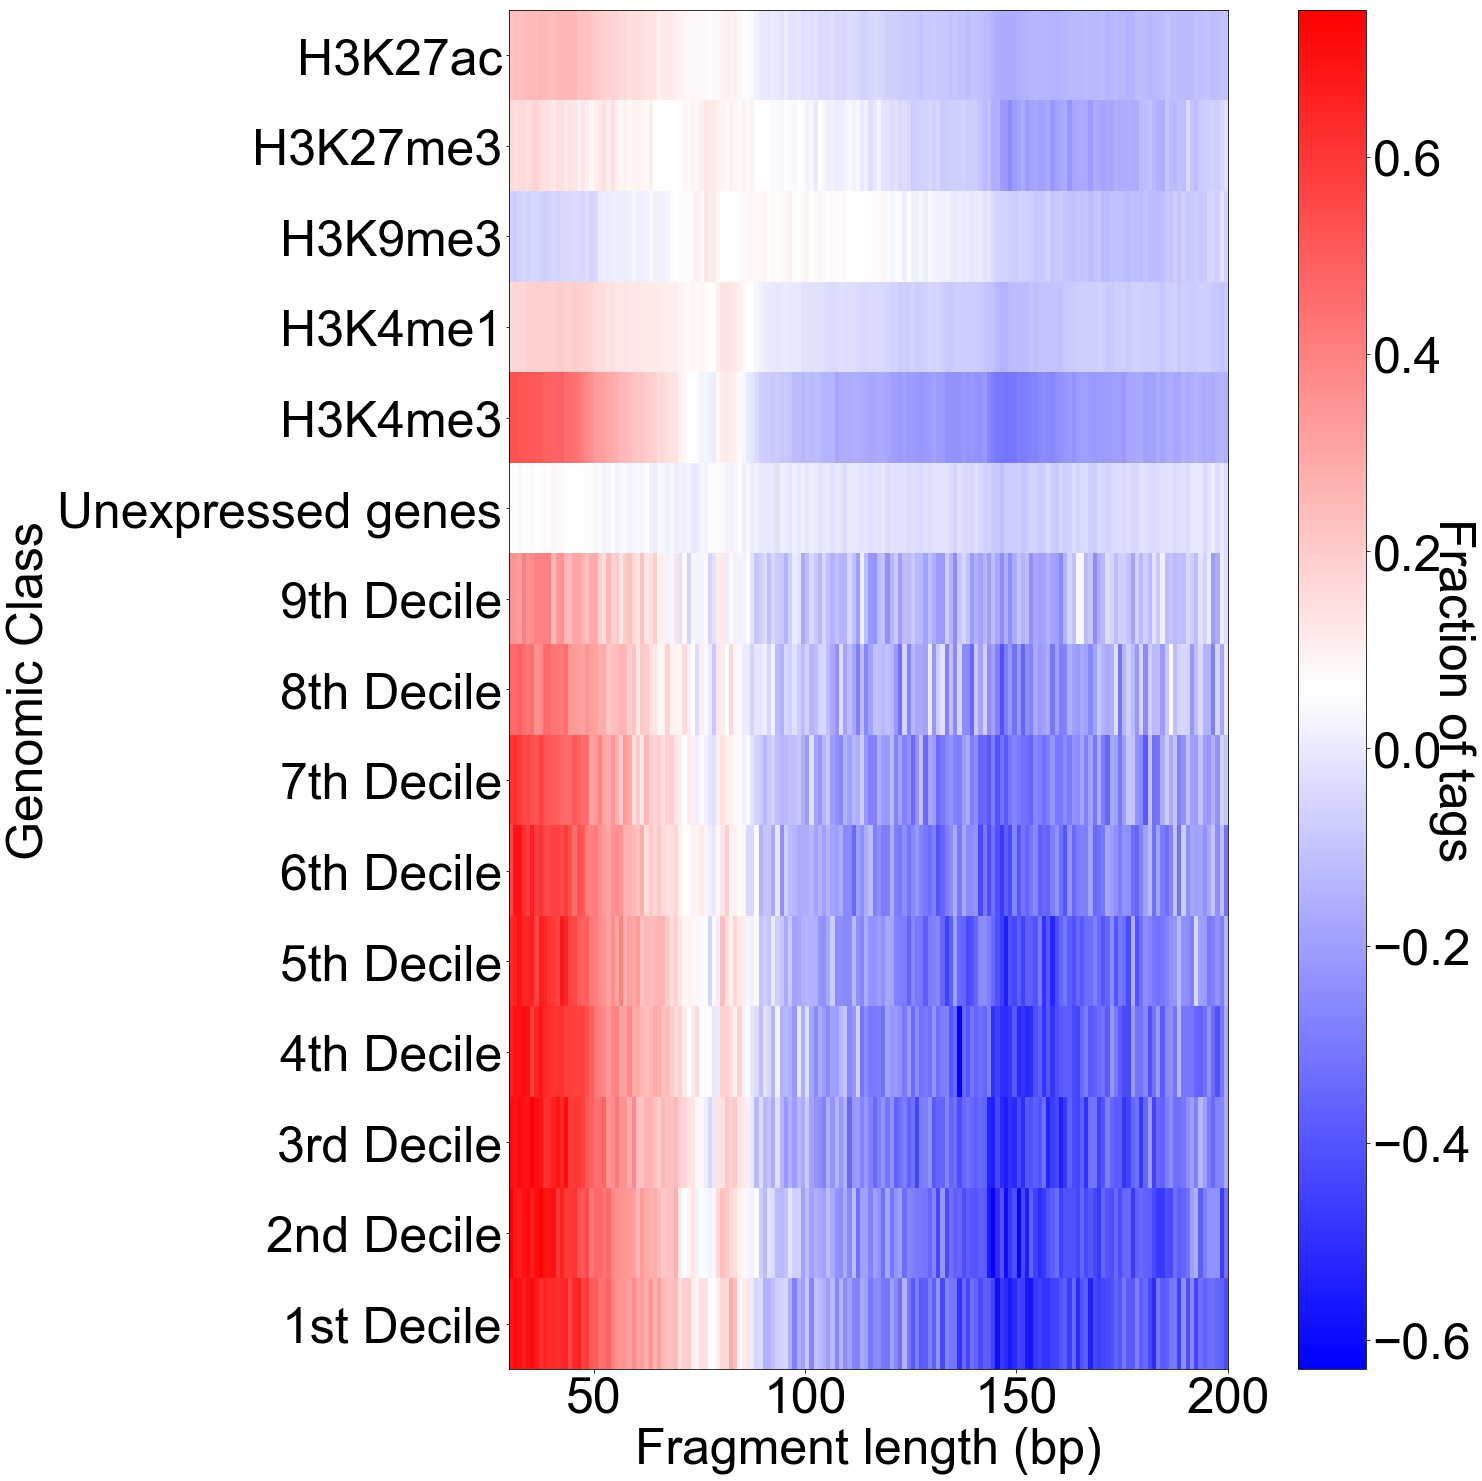

In [4]:
#This is the code to generate FIG2A
def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

def fractionate(array):
    tot = np.sum(array,axis=0)
    tot = tot.astype(float) / float(np.sum(tot))
    return tot



matrix = 0
bg_length = open("Male.mm10.sorted.deduped.bam.lengths")
bg_length_chang = open("Chang.mm10.sorted.deduped.bam.lengths")
bg_length_1min = open("1min_MNase.mm10.sorted.deduped.bam.length_distro")



male_h3k27ac = open("Male.mm10.sorted.deduped.bam.H3K27ac.length")
male_h3k27me3 = open("Male.mm10.sorted.deduped.bam.H3K27me3.length")
male_h3k9me3 = open("Male.mm10.sorted.deduped.bam.H3K9me3.length")

chang_h3k27ac = fractionate(np.load("FLFE.Chang_H3K27ac.npy"))
chang_h3k27me3 = fractionate(np.load("FLFE.Chang_H3K27me3.npy"))
chang_h3k9me3 = fractionate(np.load("FLFE.Chang_H3K9me3.npy"))
chang_h3k4me1 = fractionate(np.load("FLFE.Chang_H3K4me1.npy"))
chang_h3k4me3 = fractionate(np.load("FLFE.Chang_H3K4me3.npy"))

male_h3k4me1 = fractionate(np.load("FLFE.Male_H3K4me1.npy"))
male_h3k4me3 = fractionate(np.load("FLFE.Male_H3K4me3.npy"))

mr2_h3k27ac = fractionate(np.load("FLFE.Rando_H3K27ac.npy"))
mr2_h3k27me3 = fractionate(np.load("FLFE.Rando_H3K27me3.npy"))
mr2_h3k9me3 = fractionate(np.load("FLFE.Rando_H3K9me3.npy"))
mr2_h3k4me1 = fractionate(np.load("FLFE.Rando_H3K4me1.npy"))
mr2_h3k4me3 = fractionate(np.load("FLFE.Rando_H3K4me3.npy"))


fracs = vectorize_lengths(bg_length)
fracs2 = vectorize_lengths(bg_length_chang)
fracs3 = vectorize_lengths(bg_length_1min)

matrix = vectorize_lengths(male_h3k27ac)[:170] / fracs[:170]
matrix = np.vstack((matrix, vectorize_lengths(male_h3k27me3)[:170] / fracs[:170]))
matrix = np.vstack((matrix, vectorize_lengths(male_h3k9me3)[:170] / fracs[:170]))
matrix = np.vstack((matrix, male_h3k4me1[:170] / fracs[:170]))
matrix = np.vstack((matrix, male_h3k4me3[:170] / fracs[:170]))

matrix_chang = chang_h3k27ac[:170] / fracs2[:170]
matrix_chang = np.vstack((matrix_chang, chang_h3k27me3[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k9me3[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k4me1[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k4me3[:170] / fracs2[:170]))

matrix_mr2 = chang_h3k27ac[:170] / fracs2[:170]
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k27me3[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k9me3[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k4me1[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k4me3[:170] / fracs3[:170]))


set1 = np.load("FLFE.Male_TSS_FLFE.npy")
set1_norm = set1.astype(float) / set1.astype(float).sum(axis=1)[:,None]

set2 = np.load("FLFE.Chang_TSS_FLFE.npy")
set2_norm = set2.astype(float) / set2.astype(float).sum(axis=1)[:,None]

set3 = np.load("FLFE.Rando_TSS_FLFE.npy")
set3_norm = set3.astype(float) / set3.astype(float).sum(axis=1)[:,None]



exprs = open("mm10_TSS.flat.ESexprs")
vals = []
valid_chroms = open("mm10.chrom.sizes")
valids = {}
for line in valid_chroms:
    split = line.split()
    valids[split[0]] = True
for gene in exprs:
    if gene.split()[0] not in valids: continue
    vals.append(float(gene.split()[-1]))
vals = np.array(vals) 

ninety = np.percentile(vals[vals > 0], 90)
eighty = np.percentile(vals[vals > 0], 80)
seventy = np.percentile(vals[vals > 0], 70)
sixty = np.percentile(vals[vals > 0], 60)
fifty = np.percentile(vals[vals > 0], 50)
forty = np.percentile(vals[vals > 0], 40)
thirty = np.percentile(vals[vals > 0], 30)
twenty = np.percentile(vals[vals > 0], 20)
ten = np.percentile(vals[vals > 0], 10)

deciles = [0, ten, twenty, thirty, forty, fifty,sixty,seventy,eighty,ninety]
plts = {}

for i in range(len(deciles)):
    if i == len(deciles) - 1:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i])])
    else:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i]) & (vals < deciles[i + 1])])

    fracd = fractionate(capped1)
    fracd2 = fractionate(capped2)
    fracd3 = fractionate(capped3)
    flfe = fracd[:170] / fracs[:170]
    flfe2 = fracd2[:170] / fracs2[:170]
    flfe3 = fracd3[:170] / fracs3[:170]
    matrix = np.vstack((matrix, flfe))
    matrix_chang = np.vstack((matrix_chang, flfe2))
    matrix_mr2 = np.vstack((matrix_mr2, flfe3))

#     plt.figure(figsize=(5,5))
#     plts[i] = plt.plot(range(len(plotme1)), plotme1, c="blue")
#     #     plt.plot(range(len(plotme1)), plotme2, c="red")
#     plt.show()
#     plt.figure(figsize=(5,5))
#     plts[i] = plt.plot(range(len(fracs)), fracs, c="blue", )
#     #     plt.plot(range(len(plotme1)), plotme2, c="red")
#     plt.show()
#     plt.figure(figsize=(5,5))
#     plts[i] = plt.plot(range(len(fracd)), fracd, c="blue" )
#     #     plt.plot(range(len(plotme1)), plotme2, c="red")
#     plt.show()
labels = ["H3K27ac","H3K27me3", "H3K9me3","H3K4me1", "H3K4me3", "Unexpressed genes","9th Decile", \
          "8th Decile", "7th Decile", "6th Decile", "5th Decile", "4th Decile", "3rd Decile", "2nd Decile", "1st Decile"]

ggformat = open("FLFE_FIG2.ggplot1.txt", 'w')
for i in range(len(matrix)):
    label = labels[i]
    for j in range(len(matrix[i])):
        print >> ggformat, "%s\t%s\t%s\tMale" % (label, j + 30, matrix[i][j]) 
ggformat.close()
shifted_cmap = shiftedColorMap(cm.bwr, midpoint=0, name='shifted')
plt.figure(figsize=(25,25))    
imshow(np.log(matrix), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05).set_label('Fraction of tags', rotation=270)
plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
ax.set_ylabel("Genomic Class", fontname="Arial", fontsize=50)
ax.set_xlabel("Fragment length (bp)")
plt.savefig("/Users/vramani/Dropbox/Fig2A.pdf")
plt.show()



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:85: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in divide


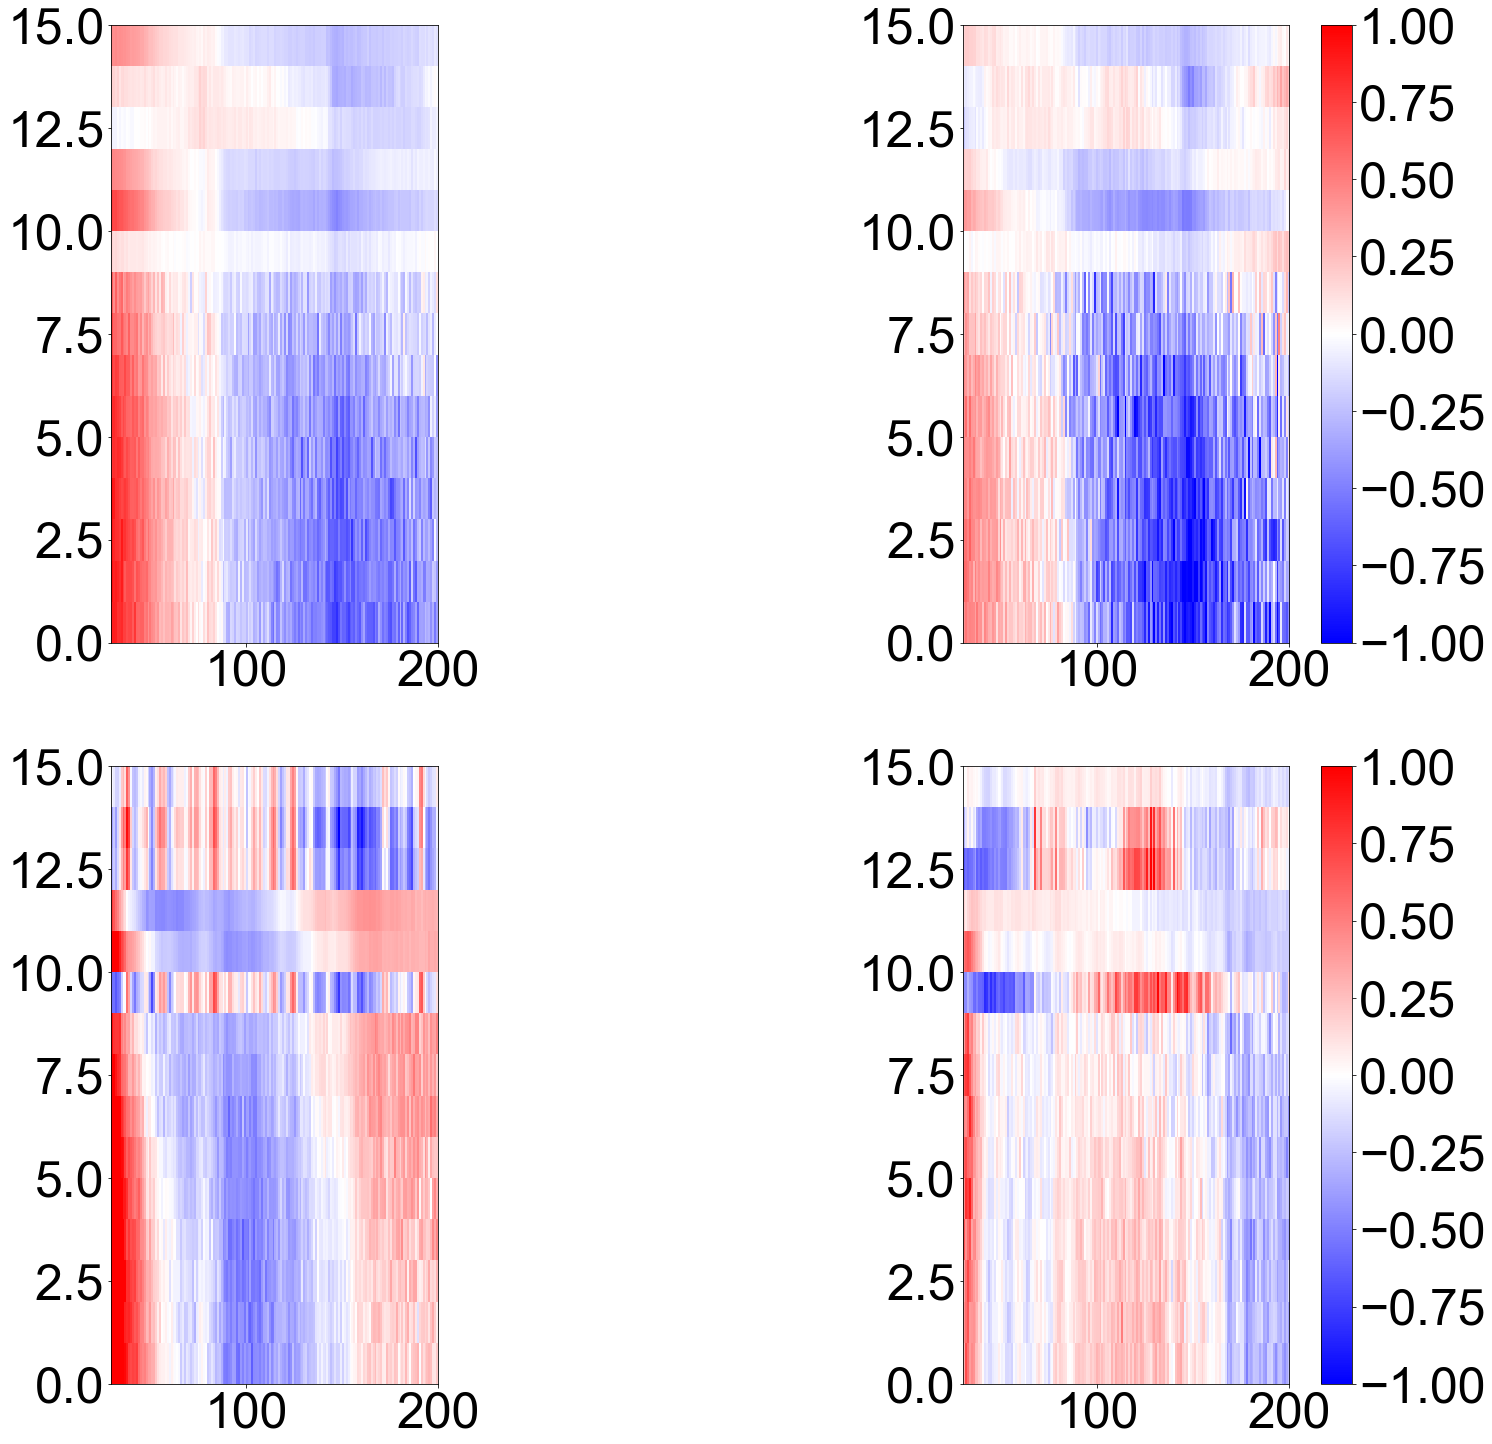

In [5]:
#This is the code to generate FIGS2
def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

def fractionate(array):
    tot = np.sum(array,axis=0)
    tot = tot.astype(float) / float(np.sum(tot))
    return tot

matrix = 0
bg_length = open("Female.mm10.sorted.deduped.bam.lengths")
bg_length_chang = open("Chang.mm10.sorted.deduped.bam.lengths")
bg_length_1min = open("1min_MNase.mm10.sorted.deduped.bam.length_distro")
bg_length_Rando = open("Rando.mm10.sorted.deduped.bam.lengths")

chang_h3k27ac = fractionate(np.load("FLFE.Chang_H3K27ac.npy"))
chang_h3k27me3 = fractionate(np.load("FLFE.Chang_H3K27me3.npy"))
chang_h3k9me3 = fractionate(np.load("FLFE.Chang_H3K9me3.npy"))
chang_h3k4me1 = fractionate(np.load("FLFE.Chang_H3K4me1.npy"))
chang_h3k4me3 = fractionate(np.load("FLFE.Chang_H3K4me3.npy"))

male_h3k27ac = fractionate(np.load("FLFE.Female_H3K27ac.npy"))
male_h3k27me3 = fractionate(np.load("FLFE.Female_H3K27me3.npy"))
male_h3k9me3 = fractionate(np.load("FLFE.Female_H3K9me3.npy"))
male_h3k4me1 = fractionate(np.load("FLFE.Female_H3K4me1.npy"))
male_h3k4me3 = fractionate(np.load("FLFE.Female_H3K4me3.npy"))

mr2_h3k27ac = fractionate(np.load("FLFE.1min_H3K27ac.npy"))
mr2_h3k27me3 = fractionate(np.load("FLFE.1min_H3K27me3.npy"))
mr2_h3k9me3 = fractionate(np.load("FLFE.1min_H3K9me3.npy"))
mr2_h3k4me1 = fractionate(np.load("FLFE.1min_H3K4me1.npy"))
mr2_h3k4me3 = fractionate(np.load("FLFE.1min_H3K4me3.npy"))

rando_h3k27ac = fractionate(np.load("FLFE.Rando_H3K27ac.npy"))
rando_h3k27me3 = fractionate(np.load("FLFE.Rando_H3K27me3.npy"))
rando_h3k9me3 = fractionate(np.load("FLFE.Rando_H3K9me3.npy"))
rando_h3k4me1 = fractionate(np.load("FLFE.Rando_H3K4me1.npy"))
rando_h3k4me3 = fractionate(np.load("FLFE.Rando_H3K4me3.npy"))

fracs = vectorize_lengths(bg_length)
fracs2 = vectorize_lengths(bg_length_chang)
fracs3 = vectorize_lengths(bg_length_1min)
fracs4 = vectorize_lengths(bg_length_Rando)

matrix = male_h3k27ac[:170] / fracs[:170]
matrix = np.vstack((matrix, male_h3k27me3[:170] / fracs[:170]))
matrix = np.vstack((matrix, male_h3k9me3[:170] / fracs[:170]))
matrix = np.vstack((matrix, male_h3k4me1[:170] / fracs[:170]))
matrix = np.vstack((matrix, male_h3k4me3[:170] / fracs[:170]))

matrix_chang = chang_h3k27ac[:170] / fracs2[:170]
matrix_chang = np.vstack((matrix_chang, chang_h3k27me3[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k9me3[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k4me1[:170] / fracs2[:170]))
matrix_chang = np.vstack((matrix_chang, chang_h3k4me3[:170] / fracs2[:170]))

matrix_mr2 = mr2_h3k27ac[:170] / fracs3[:170]
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k27me3[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k9me3[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k4me1[:170] / fracs3[:170]))
matrix_mr2 = np.vstack((matrix_mr2, mr2_h3k4me3[:170] / fracs3[:170]))

matrix_rando = rando_h3k27ac[:170] / fracs4[:170]
matrix_rando = np.vstack((matrix_rando, rando_h3k27me3[:170] / fracs4[:170]))
matrix_rando = np.vstack((matrix_rando, rando_h3k9me3[:170] / fracs4[:170]))
matrix_rando = np.vstack((matrix_rando, rando_h3k4me1[:170] / fracs4[:170]))
matrix_rando = np.vstack((matrix_rando, rando_h3k4me3[:170] / fracs4[:170]))

set1 = np.load("FLFE.Female_TSS_FLFE.npy")
set1_norm = set1.astype(float) / set1.astype(float).sum(axis=1)[:,None]

set2 = np.load("FLFE.Chang_TSS_FLFE.npy")
set2_norm = set2.astype(float) / set2.astype(float).sum(axis=1)[:,None]

set3 = np.load("FLFE.1min_Male_TSS_FLFE.npy")
set3_norm = set3.astype(float) / set3.astype(float).sum(axis=1)[:,None]

set4 = np.load("FLFE.Rando_TSS_FLFE.npy")
set4_norm = set4.astype(float) / set4.astype(float).sum(axis=1)[:,None]

exprs = open("mm10_TSS.flat.ESexprs")
vals = []
valid_chroms = open("mm10.chrom.sizes")
valids = {}
for line in valid_chroms:
    split = line.split()
    valids[split[0]] = True
for gene in exprs:
    if gene.split()[0] not in valids: continue
    vals.append(float(gene.split()[-1]))
vals = np.array(vals) 

ninety = np.percentile(vals[vals > 0], 90)
eighty = np.percentile(vals[vals > 0], 80)
seventy = np.percentile(vals[vals > 0], 70)
sixty = np.percentile(vals[vals > 0], 60)
fifty = np.percentile(vals[vals > 0], 50)
forty = np.percentile(vals[vals > 0], 40)
thirty = np.percentile(vals[vals > 0], 30)
twenty = np.percentile(vals[vals > 0], 20)
ten = np.percentile(vals[vals > 0], 10)

deciles = [0, ten, twenty, thirty, forty, fifty,sixty,seventy,eighty,ninety]
plts = {}

for i in range(len(deciles)):
    if i == len(deciles) - 1:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i])])
        capped4 = np.copy(np.nan_to_num(set4)[(vals >= deciles[i])])
    else:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped4 = np.copy(np.nan_to_num(set4)[(vals >= deciles[i]) & (vals < deciles[i + 1])])

    fracd = fractionate(capped1)
    fracd2 = fractionate(capped2)
    fracd3 = fractionate(capped3)
    fracd4 = fractionate(capped4)

    flfe = fracd[:170] / fracs[:170]
    flfe2 = fracd2[:170] / fracs2[:170]
    flfe3 = fracd3[:170] / fracs3[:170]
    flfe4 = fracd4[:170] / fracs4[:170]

    matrix = np.vstack((matrix, flfe))
    matrix_chang = np.vstack((matrix_chang, flfe2))
    matrix_mr2 = np.vstack((matrix_mr2, flfe3))
    matrix_rando = np.vstack((matrix_rando, flfe4))

labels = ["H3K27ac","H3K27me3", "H3K9me3","H3K4me1", "H3K4me3", "Unexpressed genes","9th Decile", \
          "8th Decile", "7th Decile", "6th Decile", "5th Decile", "4th Decile", "3rd Decile", "2nd Decile", "1st Decile"]

ggformat = open("FLFE_FIG2.ggplot2.txt", 'w')
for i in range(len(matrix)):
    label = labels[i]
    for j in range(len(matrix[i])):
        print >> ggformat, "%s\t%s\t%s\tFL" % (label, j + 30, matrix[i][j]) 
        print >> ggformat, "%s\t%s\t%s\tCarone et al" % (label, j + 30, matrix_rando[i][j]) 
        print >> ggformat, "%s\t%s\t%s\tATAC-seq" % (label, j + 30, matrix_chang[i][j]) 
        print >> ggformat, "%s\t%s\t%s\tML R2" % (label, j + 30, matrix_mr2[i][j]) 

ggformat.close()

shifted_cmap = shiftedColorMap(cm.bwr, midpoint=0.75, name='shifted')
plt.figure(figsize=(25,25))
subplot(221)
imshow(np.log(matrix), interpolation="none",cmap=cm.bwr, vmin=-1, vmax=1, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
#ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
#ax.set_ylabel("Genomic Class", fontname="Arial", fontsize=50)
#ax.set_xlabel("Fragment length (bp)")
subplot(222)
imshow(np.log(matrix_mr2), interpolation="none",cmap=cm.bwr, vmin=-1, vmax=1, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05)
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
subplot(223)
imshow(np.log(matrix_rando), interpolation="none",cmap=cm.bwr, vmin=-1, vmax=1, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
subplot(224)
imshow(np.log(matrix_chang), interpolation="none",cmap=cm.bwr,vmin=-1, vmax=1, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05)
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
plt.savefig("/Users/vramani/Dropbox/FigS2.pdf")
plt.show()


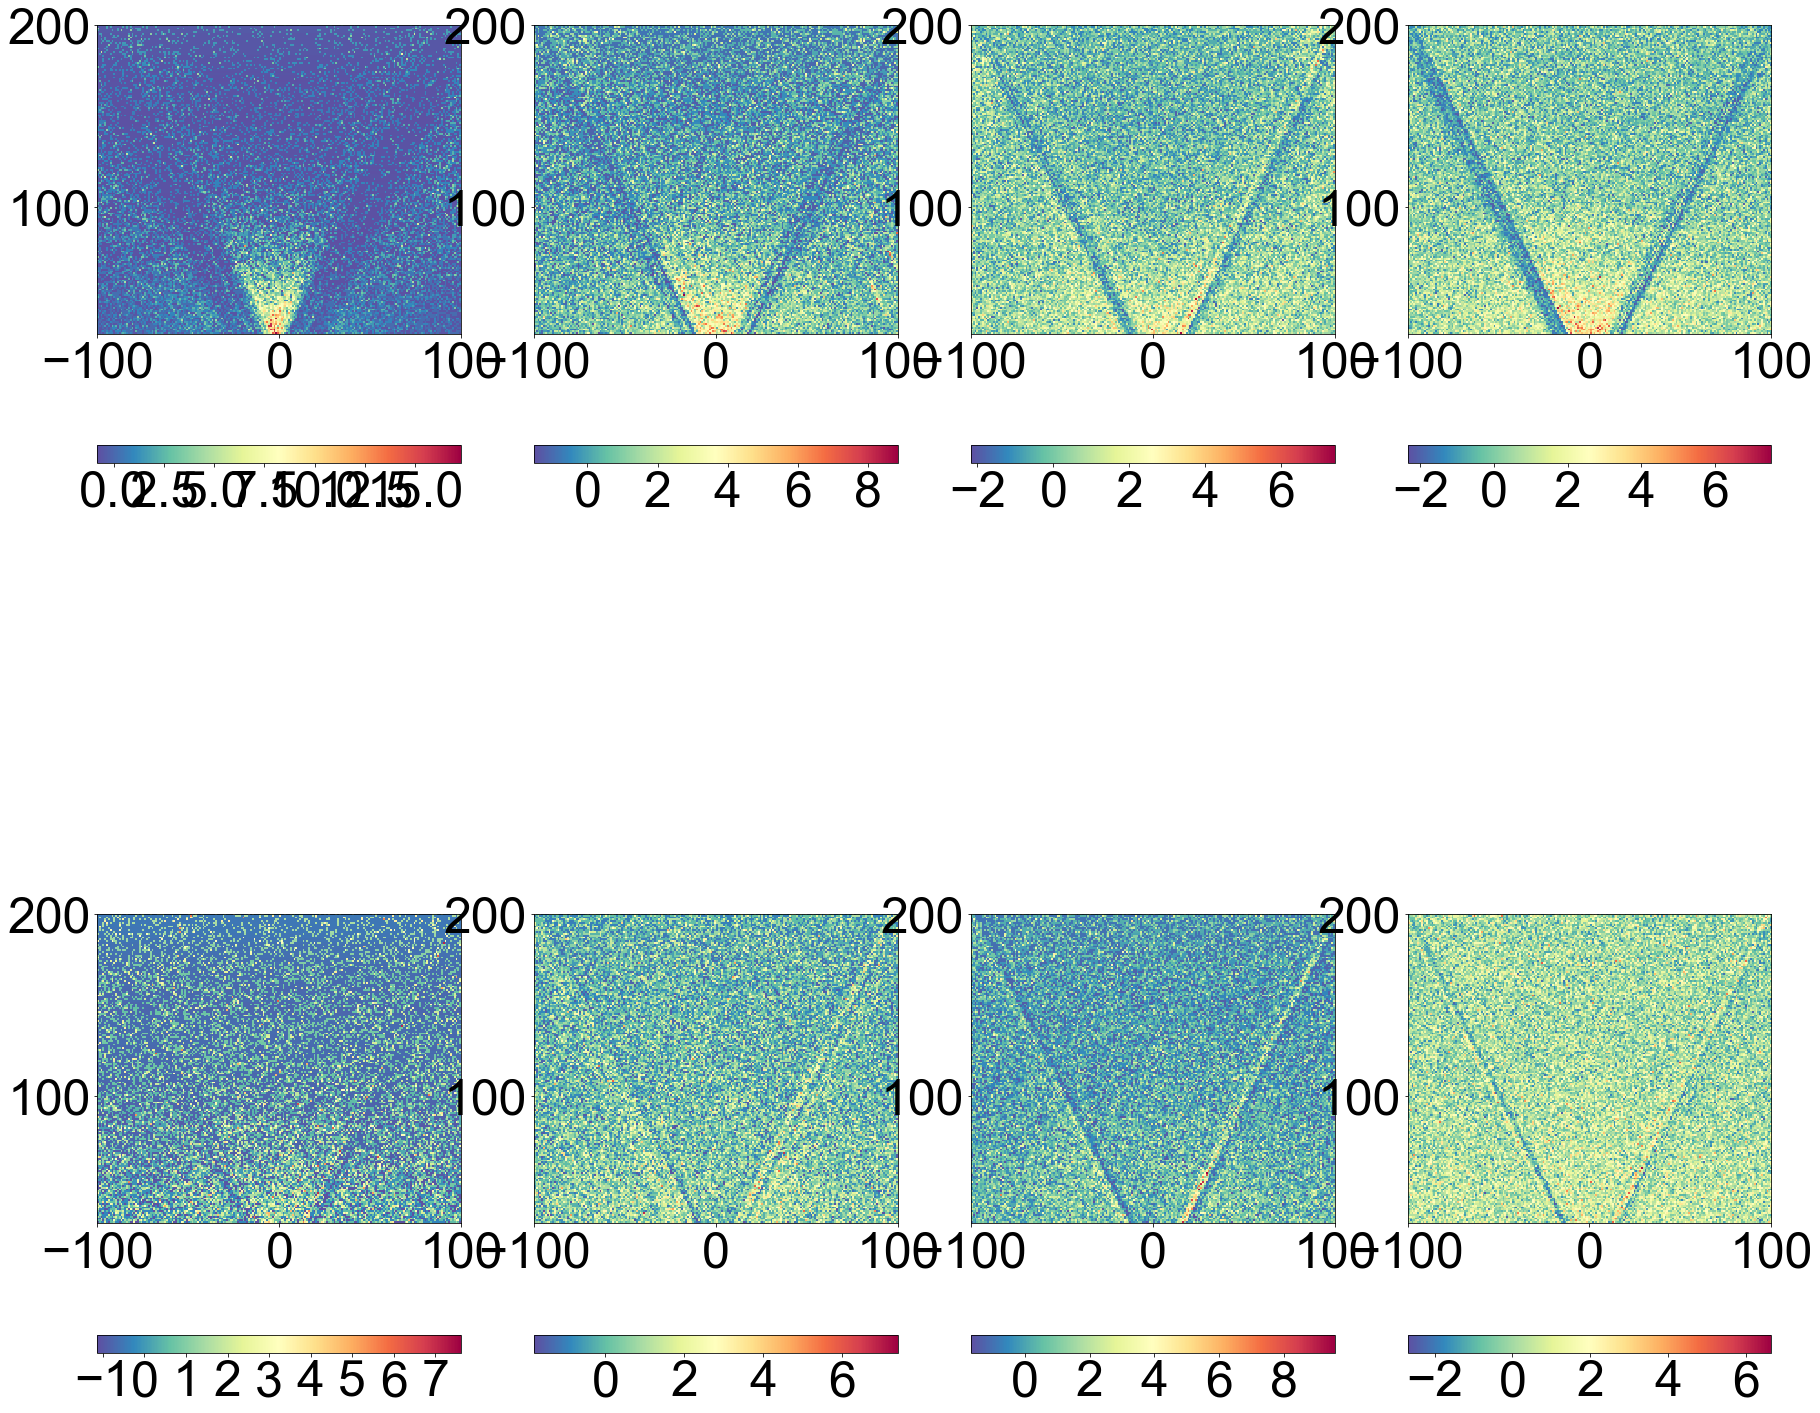

In [37]:
#FIG4A
def visualize_vplot(matrix):
    row_mean = matrix.mean(axis=1)
    row_sd = matrix.std(axis = 1)
    matrix_z = (matrix - row_mean[:,np.newaxis]) / row_sd[:, np.newaxis]
    return matrix_z

# ctcf = np.load("Vplot.plus.mid.Male_Ctcf.npy") + np.load("Vplot.minus.mid.Male_Ctcf.npy")
# ctcf_z = visualize_vplot(ctcf)

matrix = np.load("Vplot.plus.mid.Male_Rest.npy") + np.load("Vplot.minus.mid.Male_Rest.npy")
rest_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Nrf1.npy") + np.load("Vplot.minus.mid.Male_Nrf1.npy")
nrf1_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Yy1.npy") + np.load("Vplot.minus.mid.Male_Yy1.npy")
yy1_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Sox2.npy") + np.load("Vplot.minus.mid.Male_Sox2.npy")
sox2_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Oct4.npy") + np.load("Vplot.minus.mid.Male_Oct4.npy")
oct4_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Klf4.npy") + np.load("Vplot.minus.mid.Male_Klf4.npy")
klf4_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Esrrb.npy") + np.load("Vplot.minus.mid.Male_Esrrb.npy")
esrrb_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_cMyc.npy") + np.load("Vplot.minus.mid.Male_cMyc.npy")
cmyc_z = visualize_vplot(matrix)

plt.figure(figsize=(30,30))
subplot(241)
imshow(rest_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(242)
imshow(nrf1_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(243)
imshow(yy1_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(244)
imshow(klf4_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(245)
imshow(cmyc_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(246)
imshow(oct4_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(247)
imshow(sox2_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(248)
imshow(esrrb_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
plt.savefig("/Users/vramani/Dropbox/Fig4.pdf")
plt.show()

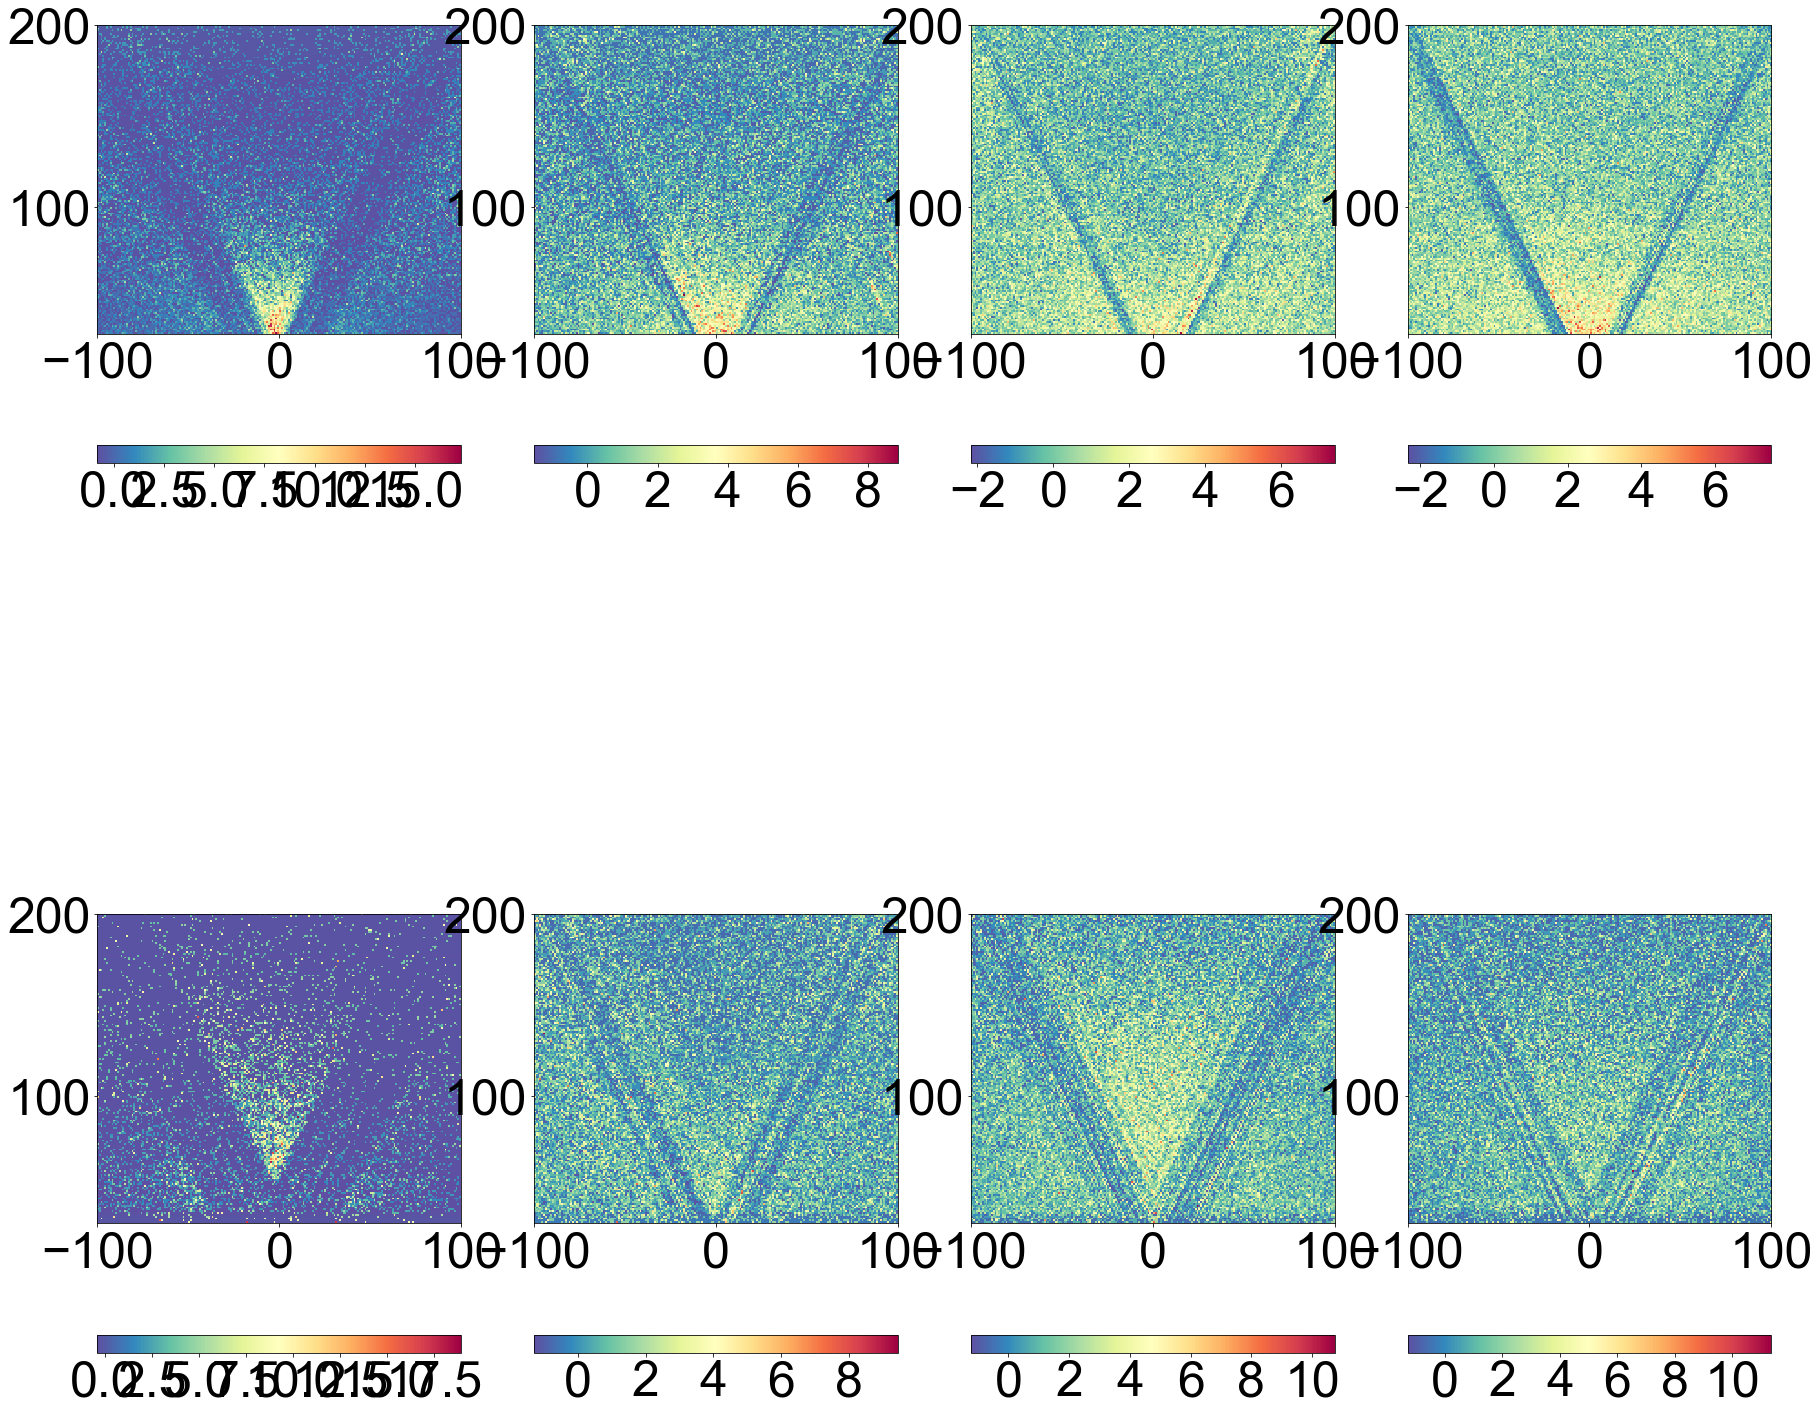

In [7]:
#FIG4A
def visualize_vplot(matrix):
    row_mean = matrix.mean(axis=1)
    row_sd = matrix.std(axis = 1)
    matrix_z = (matrix - row_mean[:,np.newaxis]) / row_sd[:, np.newaxis]
    return matrix_z
#   return np.log(matrix)

# ctcf = np.load("Vplot.plus.mid.Male_Ctcf.npy") + np.load("Vplot.minus.mid.Male_Ctcf.npy")
# ctcf_z = visualize_vplot(ctcf)

matrix = np.load("Vplot.plus.mid.Male_Rest.npy") + np.load("Vplot.minus.mid.Male_Rest.npy")
rest_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Nrf1.npy") + np.load("Vplot.minus.mid.Male_Nrf1.npy")
nrf1_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Yy1.npy") + np.load("Vplot.minus.mid.Male_Yy1.npy")
yy1_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Male_Klf4.npy") + np.load("Vplot.minus.mid.Male_Klf4.npy")
klf4_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Chang_Rest.npy") + np.load("Vplot.minus.mid.Chang_Rest.npy")
cmyc_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Chang_Nrf1.npy") + np.load("Vplot.minus.mid.Chang_Nrf1.npy")
sox2_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Chang_Yy1.npy") + np.load("Vplot.minus.mid.Chang_Yy1.npy")
oct4_z = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.Chang_Klf4.npy") + np.load("Vplot.minus.mid.Chang_Klf4.npy")
esrrb_z = visualize_vplot(matrix)

plt.figure(figsize=(30,30))
subplot(241)
imshow(rest_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(242)
imshow(nrf1_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(243)
imshow(yy1_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(244)
imshow(klf4_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(245)
imshow(cmyc_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(246)
imshow(oct4_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(247)
imshow(sox2_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
subplot(248)
imshow(esrrb_z[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(orientation="horizontal")
plt.savefig("/Users/vijayramani/Dropbox/FigSX.pdf")
plt.show()

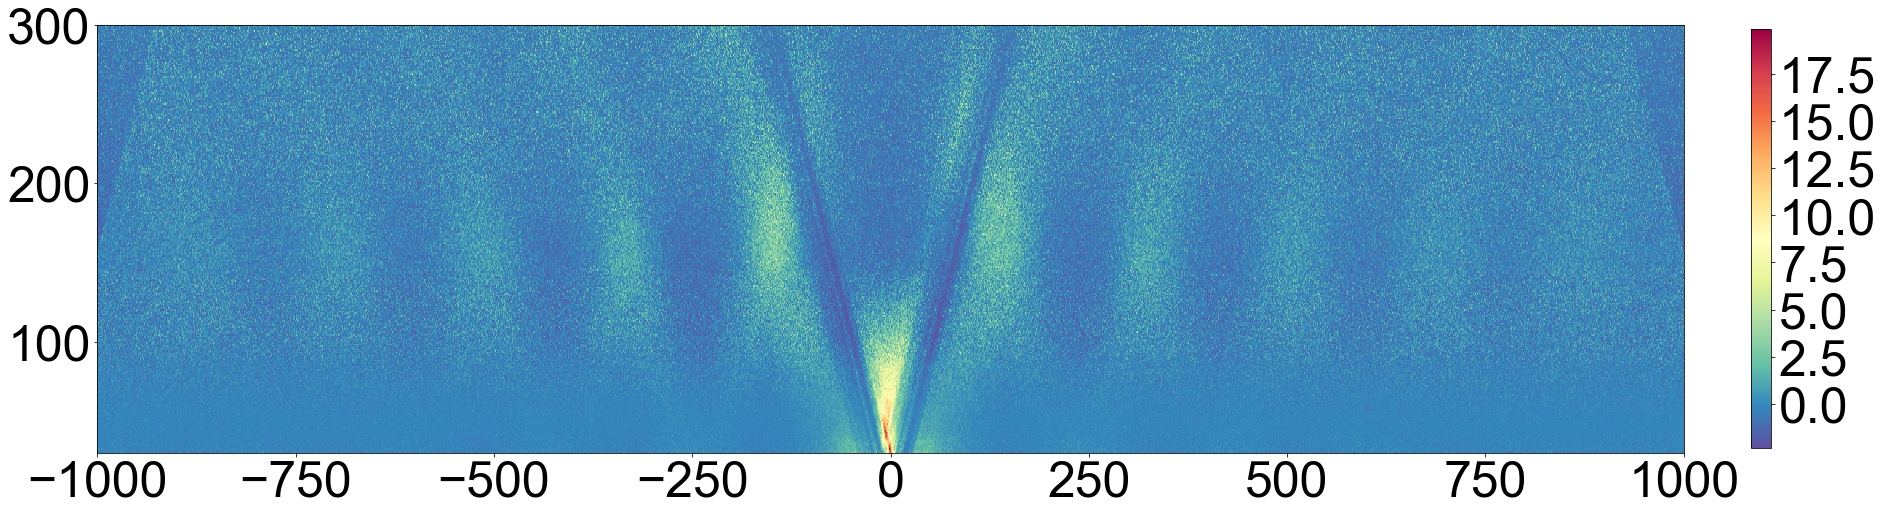

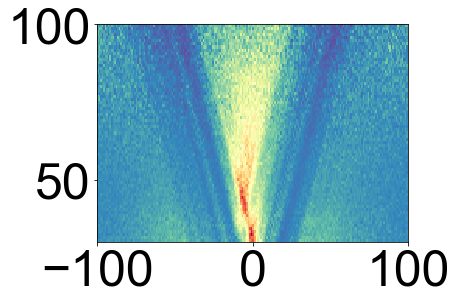

In [49]:
fho = open("Male_chr12_1D.txt", 'w')
TSS1 = np.load("Vplot.plus.mid.Male_Ctcf.npy")
TSS2 = np.load("Vplot.minus.mid.Male_Ctcf.npy")
TSS = TSS1 + TSS2
TSS_short = TSS
row_mean = TSS_short.mean(axis=1)
row_sd = TSS_short.std(axis = 1)
row_sum = TSS_short.sum(axis=1)

# short = running_mean_vec(normalize_vec(np.average(TSS_short[250:, ],axis=0)), 50)
# med1 = running_mean_vec(normalize_vec(np.average(TSS_short[230:249, ],axis=0)), 50)
# med2 = running_mean_vec(normalize_vec(np.average(TSS_short[210:229, ],axis=0)), 50)
# med3 = running_mean_vec(normalize_vec(np.average(TSS_short[190:209, ],axis=0)), 50)
# med4 = running_mean_vec(normalize_vec(np.average(TSS_short[160:189, ],axis=0)), 50)
# longer = running_mean_vec(normalize_vec(np.average(TSS_short[110:159, ],axis=0)), 50)

# for i in range(len(short)):
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, short[i], "30 - 50 bp", "#1f78b4")
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, med1[i], "51 - 70 bp", "#33a02c")
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, med2[i], "71 - 90 bp", "#e31a1c")
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, med3[i], "91 - 110 bp", "#ff7f00")
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, med4[i], "111 - 140 bp", "#6a3d9a")
#     print >> fho, "%s\t%s\t%s\t%s" % (i - len(short) / 2, longer[i], "141 - 190 bp","#b15928")

# fho.close()
# plt.figure(figsize=(20,10))
# plt.plot(range(len(short)), short, c="#1f78b4",linewidth=2)
# plt.plot(range(len(med1)), med1, c="#33a02c",linewidth=2)
# plt.plot(range(len(med2)), med2, c="#e31a1c",linewidth=2)
# plt.plot(range(len(med3)), med3, c="#ff7f00",linewidth=2)
# plt.plot(range(len(med4)), med4, c="#6a3d9a",linewidth=2)
# plt.plot(range(len(longer)), longer, c="#b15928",linewidth=2)
# plt.show() 

TSS_fraction = TSS_short.astype(float)/ TSS_short.sum(axis=1)[:,None].astype(float)
TSS_z = (TSS_short - row_mean[:,np.newaxis]) / row_sd[:, np.newaxis]
TSS_z_capped = np.copy(TSS_z[:,::-1])
#TSS_z_capped[TSS_z_capped >= np.percentile(TSS_z_capped, 99)] = np.percentile(TSS_z_capped, 99)
plt.figure(figsize=(30,15))
imshow(TSS_z_capped, interpolation="none", cmap=cm.Spectral_r, extent=[-1000,1000,30,300], aspect=2)
#plt.rcParams["figure.figsize"] = (10,5)
#plt.axes().set_aspect('equal', 'datalim')
colorbar(fraction=0.0125, pad=.04)
plt.savefig("/Users/vramani/Dropbox/Fig5A.pdf")
plt.show()

imshow(TSS_z_capped[200:,900:1100], interpolation="none", cmap=cm.Spectral_r, extent=[-100,100,30,100], aspect=2)
#plt.rcParams["figure.figsize"] = (10,5)
#plt.axes().set_aspect('equal', 'datalim')
#colorbar(fraction=0.01, pad=.04)
plt.savefig("/Users/vramani/Dropbox/Fig5inset.pdf")
plt.show()



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:138: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: divide by zero encountered in log


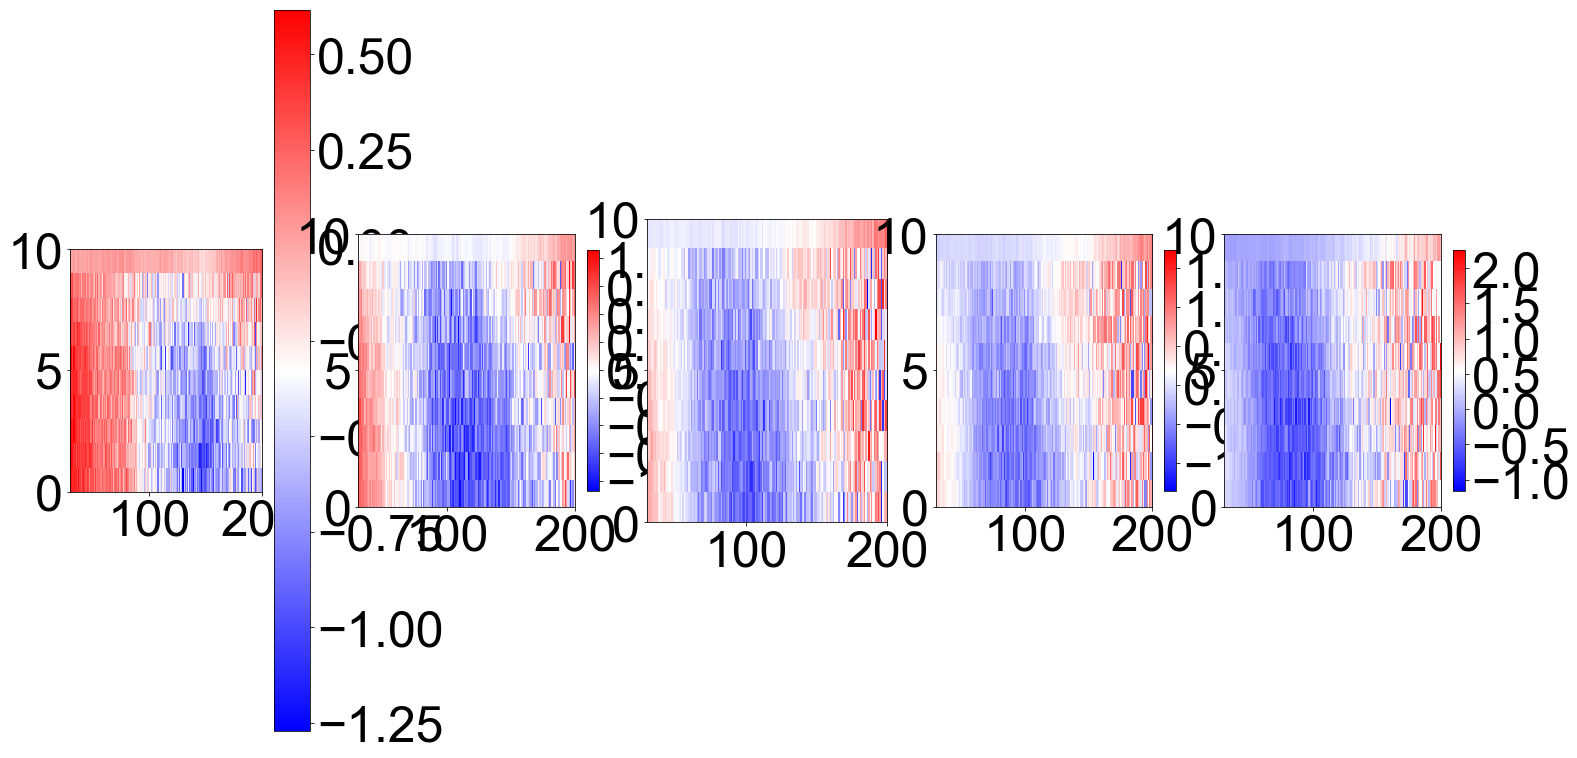

In [71]:
#This is the code to generate FIGS2
def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

def fractionate(array):
    tot = np.sum(array,axis=0)
    tot = tot.astype(float) / float(np.sum(tot))
    return tot

matrix = 0
bg_length_1min = open("1min_MNase.mm10.sorted.deduped.bam.length_distro")
bg_length_2_5min = open("2_5min_MNase.mm10.sorted.deduped.bam.length_distro")
bg_length_5min = open("5min_MNase.mm10.sorted.deduped.bam.length_distro")
bg_length_10min = open("10min_MNase.mm10.sorted.deduped.bam.length_distro")
bg_length_20min = open("20min_MNase.mm10.sorted.deduped.bam.length_distro")


fracs = vectorize_lengths(bg_length_1min)
fracs2 = vectorize_lengths(bg_length_2_5min)
fracs3 = vectorize_lengths(bg_length_5min)
fracs4 = vectorize_lengths(bg_length_10min)
fracs5 = vectorize_lengths(bg_length_20min)


set1 = np.load("FLFE.1min_Male_TSS_FLFE.npy")
set1_norm = set1.astype(float) / set1.astype(float).sum(axis=1)[:,None]

set2 = np.load("FLFE.2_5min_Male_TSS_FLFE.npy")
set2_norm = set2.astype(float) / set2.astype(float).sum(axis=1)[:,None]

set3 = np.load("FLFE.5min_Male_TSS_FLFE.npy")
set3_norm = set3.astype(float) / set3.astype(float).sum(axis=1)[:,None]

set4 = np.load("FLFE.10min_Male_TSS_FLFE.npy")
set4_norm = set4.astype(float) / set4.astype(float).sum(axis=1)[:,None]

set5 = np.load("FLFE.20min_Male_TSS_FLFE.npy")
set5_norm = set5.astype(float) / set5.astype(float).sum(axis=1)[:,None]


exprs = open("mm10_TSS.flat.ESexprs")
vals = []
valid_chroms = open("mm10.chrom.sizes")
valids = {}
for line in valid_chroms:
    split = line.split()
    valids[split[0]] = True
for gene in exprs:
    if gene.split()[0] not in valids: continue
    vals.append(float(gene.split()[-1]))
vals = np.array(vals) 

ninety = np.percentile(vals[vals > 0], 90)
eighty = np.percentile(vals[vals > 0], 80)
seventy = np.percentile(vals[vals > 0], 70)
sixty = np.percentile(vals[vals > 0], 60)
fifty = np.percentile(vals[vals > 0], 50)
forty = np.percentile(vals[vals > 0], 40)
thirty = np.percentile(vals[vals > 0], 30)
twenty = np.percentile(vals[vals > 0], 20)
ten = np.percentile(vals[vals > 0], 10)

deciles = [0, ten, twenty, thirty, forty, fifty,sixty,seventy,eighty,ninety]
plts = {}
cnt = 0
for i in range(len(deciles)):
    if i == len(deciles) - 1:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i])])
        capped4 = np.copy(np.nan_to_num(set4)[(vals >= deciles[i])])
        capped5 = np.copy(np.nan_to_num(set5)[(vals >= deciles[i])])

    else:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped4 = np.copy(np.nan_to_num(set4)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped5 = np.copy(np.nan_to_num(set5)[(vals >= deciles[i]) & (vals < deciles[i + 1])])

    fracd = fractionate(capped1)
    fracd2 = fractionate(capped2)
    fracd3 = fractionate(capped3)
    fracd4 = fractionate(capped4)
    fracd5 = fractionate(capped5)
    
    flfe = fracd[:170] / fracs[:170]
    flfe2 = fracd2[:170] / fracs2[:170]
    flfe3 = fracd3[:170] / fracs3[:170]
    flfe4 = fracd4[:170] / fracs4[:170]
    flfe5 = fracd5[:170] / fracs5[:170]
    
    if cnt == 0:
        matrix = flfe
        matrix_2 = flfe2
        matrix_3 = flfe3
        matrix_4 = flfe4
        matrix_5 = flfe5
        cnt +=1
    else:
        matrix = np.vstack((matrix, flfe))
        matrix_2 = np.vstack((matrix_2, flfe2))
        matrix_3 = np.vstack((matrix_3, flfe3))
        matrix_4 = np.vstack((matrix_4, flfe4))
        matrix_5 = np.vstack((matrix_5, flfe5))

labels = ["Unexpressed genes","9th Decile", \
          "8th Decile", "7th Decile", "6th Decile", "5th Decile", "4th Decile", "3rd Decile", "2nd Decile", "1st Decile"]

shifted_cmap = shiftedColorMap(cm.bwr, midpoint=0.75, name='shifted')
plt.figure(figsize=(25,25))
subplot(151)
imshow(np.log(matrix), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar()
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
#ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
#ax.set_ylabel("Genomic Class", fontname="Arial", fontsize=50)
#ax.set_xlabel("Fragment length (bp)")
subplot(152)
imshow(np.log(matrix_2), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05)
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
subplot(153)
imshow(np.log(matrix_3), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
subplot(154)
imshow(np.log(matrix_4), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05)
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
subplot(155)
imshow(np.log(matrix_5), interpolation="none",cmap=cm.bwr, aspect=float(150)/float(7), extent=[30,200,0,len(matrix)])
colorbar(fraction=0.05)
#plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis

# plt.savefig("/Users/vramani/Dropbox/Fig6A.pdf")
# plt.show()

fho = open("FIG6A.txt", 'w')
for i in range(len(matrix[:,20])):
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix[:,:20],axis=1)[i],np.std(matrix[:,:20],axis=1)[i], "ML R2") 
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_2[:,:20],axis=1)[i],np.std(matrix_2[:,:20],axis=1)[i], "2.5 min")
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_3[:,:20],axis=1)[i],np.std(matrix_3[:,:20],axis=1)[i], "5 min")
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_4[:,:20],axis=1)[i],np.std(matrix_4[:,:20],axis=1)[i], "10 min")
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_5[:,:20],axis=1)[i],np.std(matrix_5[:,:20],axis=1)[i], "20 min")
fho.close()



In [11]:
#This is the code to generate FIGS2
def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

def fractionate(array):
    tot = np.sum(array,axis=0)
    tot = tot.astype(float) / float(np.sum(tot))
    return tot

matrix = 0
bg_length_1min = open("Male.mm10.sorted.deduped.bam.lengths")
bg_length_2_5min = open("Female.mm10.sorted.deduped.bam.lengths")
bg_length_5min = open("Chang.mm10.sorted.deduped.bam.lengths")


fracs = vectorize_lengths(bg_length_1min)
fracs2 = vectorize_lengths(bg_length_2_5min)
fracs3 = vectorize_lengths(bg_length_5min)


set1 = np.load("FLFE.Male_TSS_FLFE.npy")
set1_norm = set1.astype(float) / set1.astype(float).sum(axis=1)[:,None]

set2 = np.load("FLFE.Female_TSS_FLFE.npy")
set2_norm = set2.astype(float) / set2.astype(float).sum(axis=1)[:,None]

set3 = np.load("FLFE.Chang_TSS_FLFE.npy")
set3_norm = set3.astype(float) / set3.astype(float).sum(axis=1)[:,None]



exprs = open("mm10_TSS.flat.ESexprs")
vals = []
valid_chroms = open("mm10.chrom.sizes")
valids = {}
for line in valid_chroms:
    split = line.split()
    valids[split[0]] = True
for gene in exprs:
    if gene.split()[0] not in valids: continue
    vals.append(float(gene.split()[-1]))
vals = np.array(vals) 

ninety = np.percentile(vals[vals > 0], 90)
eighty = np.percentile(vals[vals > 0], 80)
seventy = np.percentile(vals[vals > 0], 70)
sixty = np.percentile(vals[vals > 0], 60)
fifty = np.percentile(vals[vals > 0], 50)
forty = np.percentile(vals[vals > 0], 40)
thirty = np.percentile(vals[vals > 0], 30)
twenty = np.percentile(vals[vals > 0], 20)
ten = np.percentile(vals[vals > 0], 10)

deciles = [0, ten, twenty, thirty, forty, fifty,sixty,seventy,eighty,ninety]
plts = {}
cnt = 0
for i in range(len(deciles)):
    if i == len(deciles) - 1:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i])])

    else:
        capped1 = np.copy(np.nan_to_num(set1)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped2 = np.copy(np.nan_to_num(set2)[(vals >= deciles[i]) & (vals < deciles[i + 1])])
        capped3 = np.copy(np.nan_to_num(set3)[(vals >= deciles[i]) & (vals < deciles[i + 1])])

    fracd = fractionate(capped1)
    fracd2 = fractionate(capped2)
    fracd3 = fractionate(capped3)
    
    flfe = fracd[:170] / fracs[:170]
    flfe2 = fracd2[:170] / fracs2[:170]
    flfe3 = fracd3[:170] / fracs3[:170]
    
    if cnt == 0:
        matrix = flfe
        matrix_2 = flfe2
        matrix_3 = flfe3
        cnt +=1
    else:
        matrix = np.vstack((matrix, flfe))
        matrix_2 = np.vstack((matrix_2, flfe2))
        matrix_3 = np.vstack((matrix_3, flfe3))

labels = ["Unexpressed genes","9th Decile", \
          "8th Decile", "7th Decile", "6th Decile", "5th Decile", "4th Decile", "3rd Decile", "2nd Decile", "1st Decile"]


# plt.savefig("/Users/vramani/Dropbox/Fig6A.pdf")
# plt.show()

fho = open("FIG2A.txt", 'w')
for i in range(len(matrix[:,20])):
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix[:,:20],axis=1)[i],np.std(matrix[:,:20],axis=1)[i], "ML") 
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_2[:,:20],axis=1)[i],np.std(matrix_2[:,:20],axis=1)[i], "FL")
    print >> fho, "%s\t%s\t%s\t%s" % (i, np.mean(matrix_3[:,:20],axis=1)[i],np.std(matrix_3[:,:20],axis=1)[i], "ATAC-seq")
fho.close()



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in divide


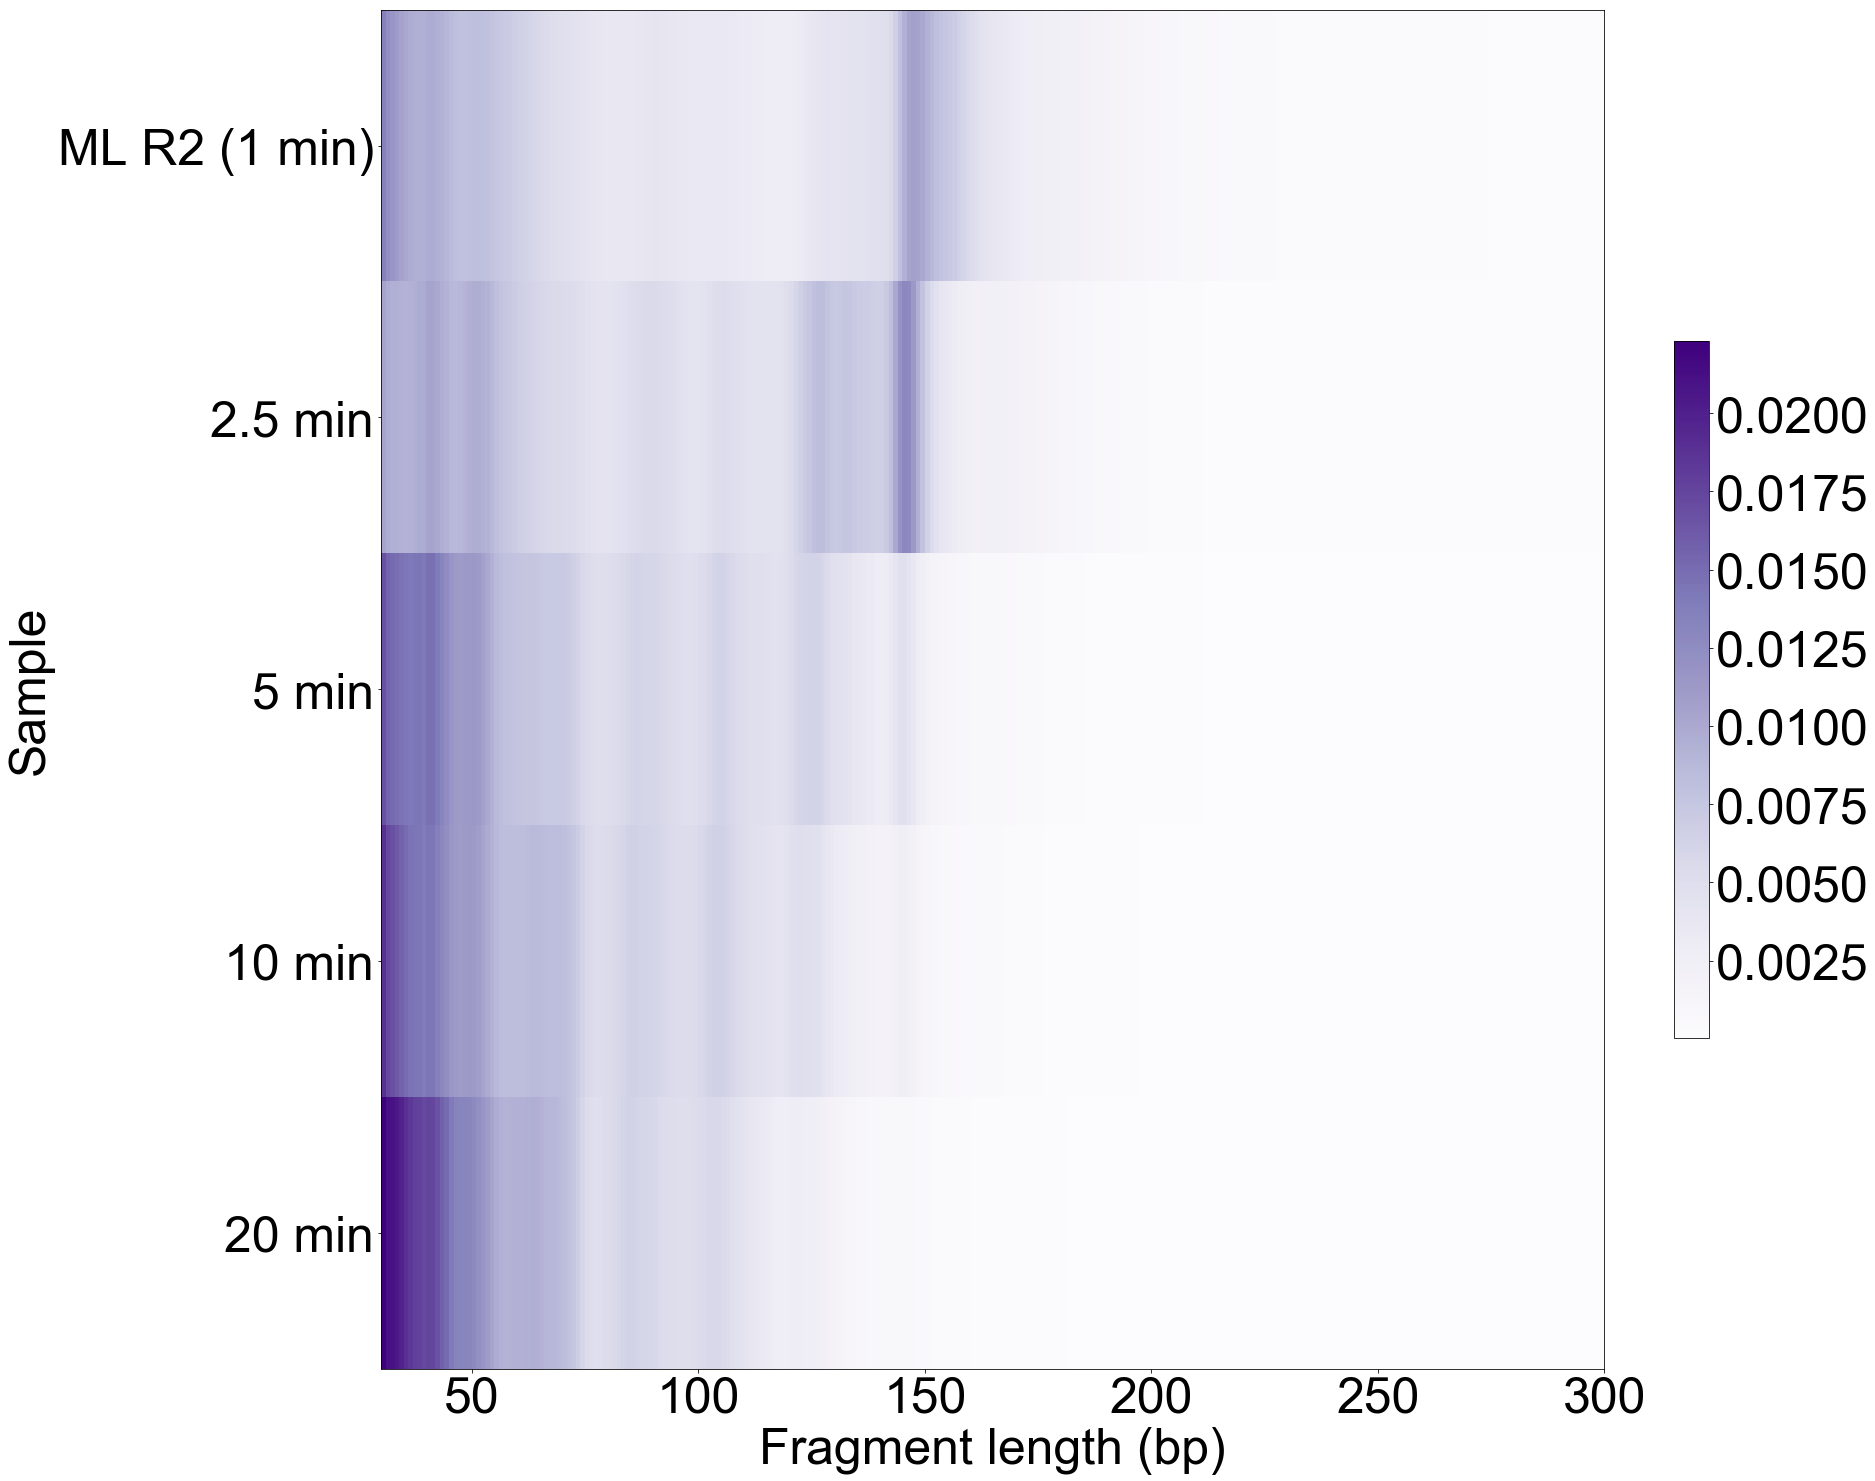

In [12]:
male_ssp_1min = open("1min_MNase.mm10.sorted.deduped.bam.length_distro")
male_ssp_2_5min = open("2_5min_MNase.mm10.sorted.deduped.bam.length_distro")
male_ssp_5min = open("5min_MNase.mm10.sorted.deduped.bam.length_distro")
male_ssp_10min = open("10min_MNase.mm10.sorted.deduped.bam.length_distro")
male_ssp_20min = open("20min_MNase.mm10.sorted.deduped.bam.length_distro")

fhis = [male_ssp_1min, male_ssp_2_5min, male_ssp_5min, male_ssp_10min, male_ssp_20min]
labels = ["ML R2 (1 min)", "2.5 min","5 min", "10 min", "20 min"]

matrix = vectorize_lengths(male_ssp_1min)

for i in fhis[1:]:
    matrix = np.vstack((matrix, vectorize_lengths(i)))
    i.close()
    
num_samp = len(matrix)

ggformat = open("FLFE_FIGS5.ggplot2.txt", 'w')
for i in range(len(matrix)):
    label = labels[i]
    for j in range(len(matrix[i])):
        print >> ggformat, "%s\t%s\t%s\tML R2" % (label, j + 30, matrix[i][j]) 
ggformat.close()

ggformat.close()
plt.figure(figsize=(25,25))    
imshow(matrix, interpolation="none",cmap=cm.Purples, aspect=float(150)/float(num_samp) * 2, extent=[30,300,0,num_samp])
colorbar(fraction=0.025)
plt.yticks(np.arange(len(labels))+0.5, labels)
ax = plt.gca() # grab the current axis
ax.set_yticklabels(labels[::-1]) # set the labels to display at those ticks
ax.set_ylabel("Sample", fontname="Arial", fontsize=50)
ax.set_xlabel("Fragment length (bp)")
plt.savefig("/Users/vramani/Dropbox/FigS5B.pdf")
plt.show()


2.7040290335
2.93330015207
3.08552145368
3.09690176188
3.32979885804


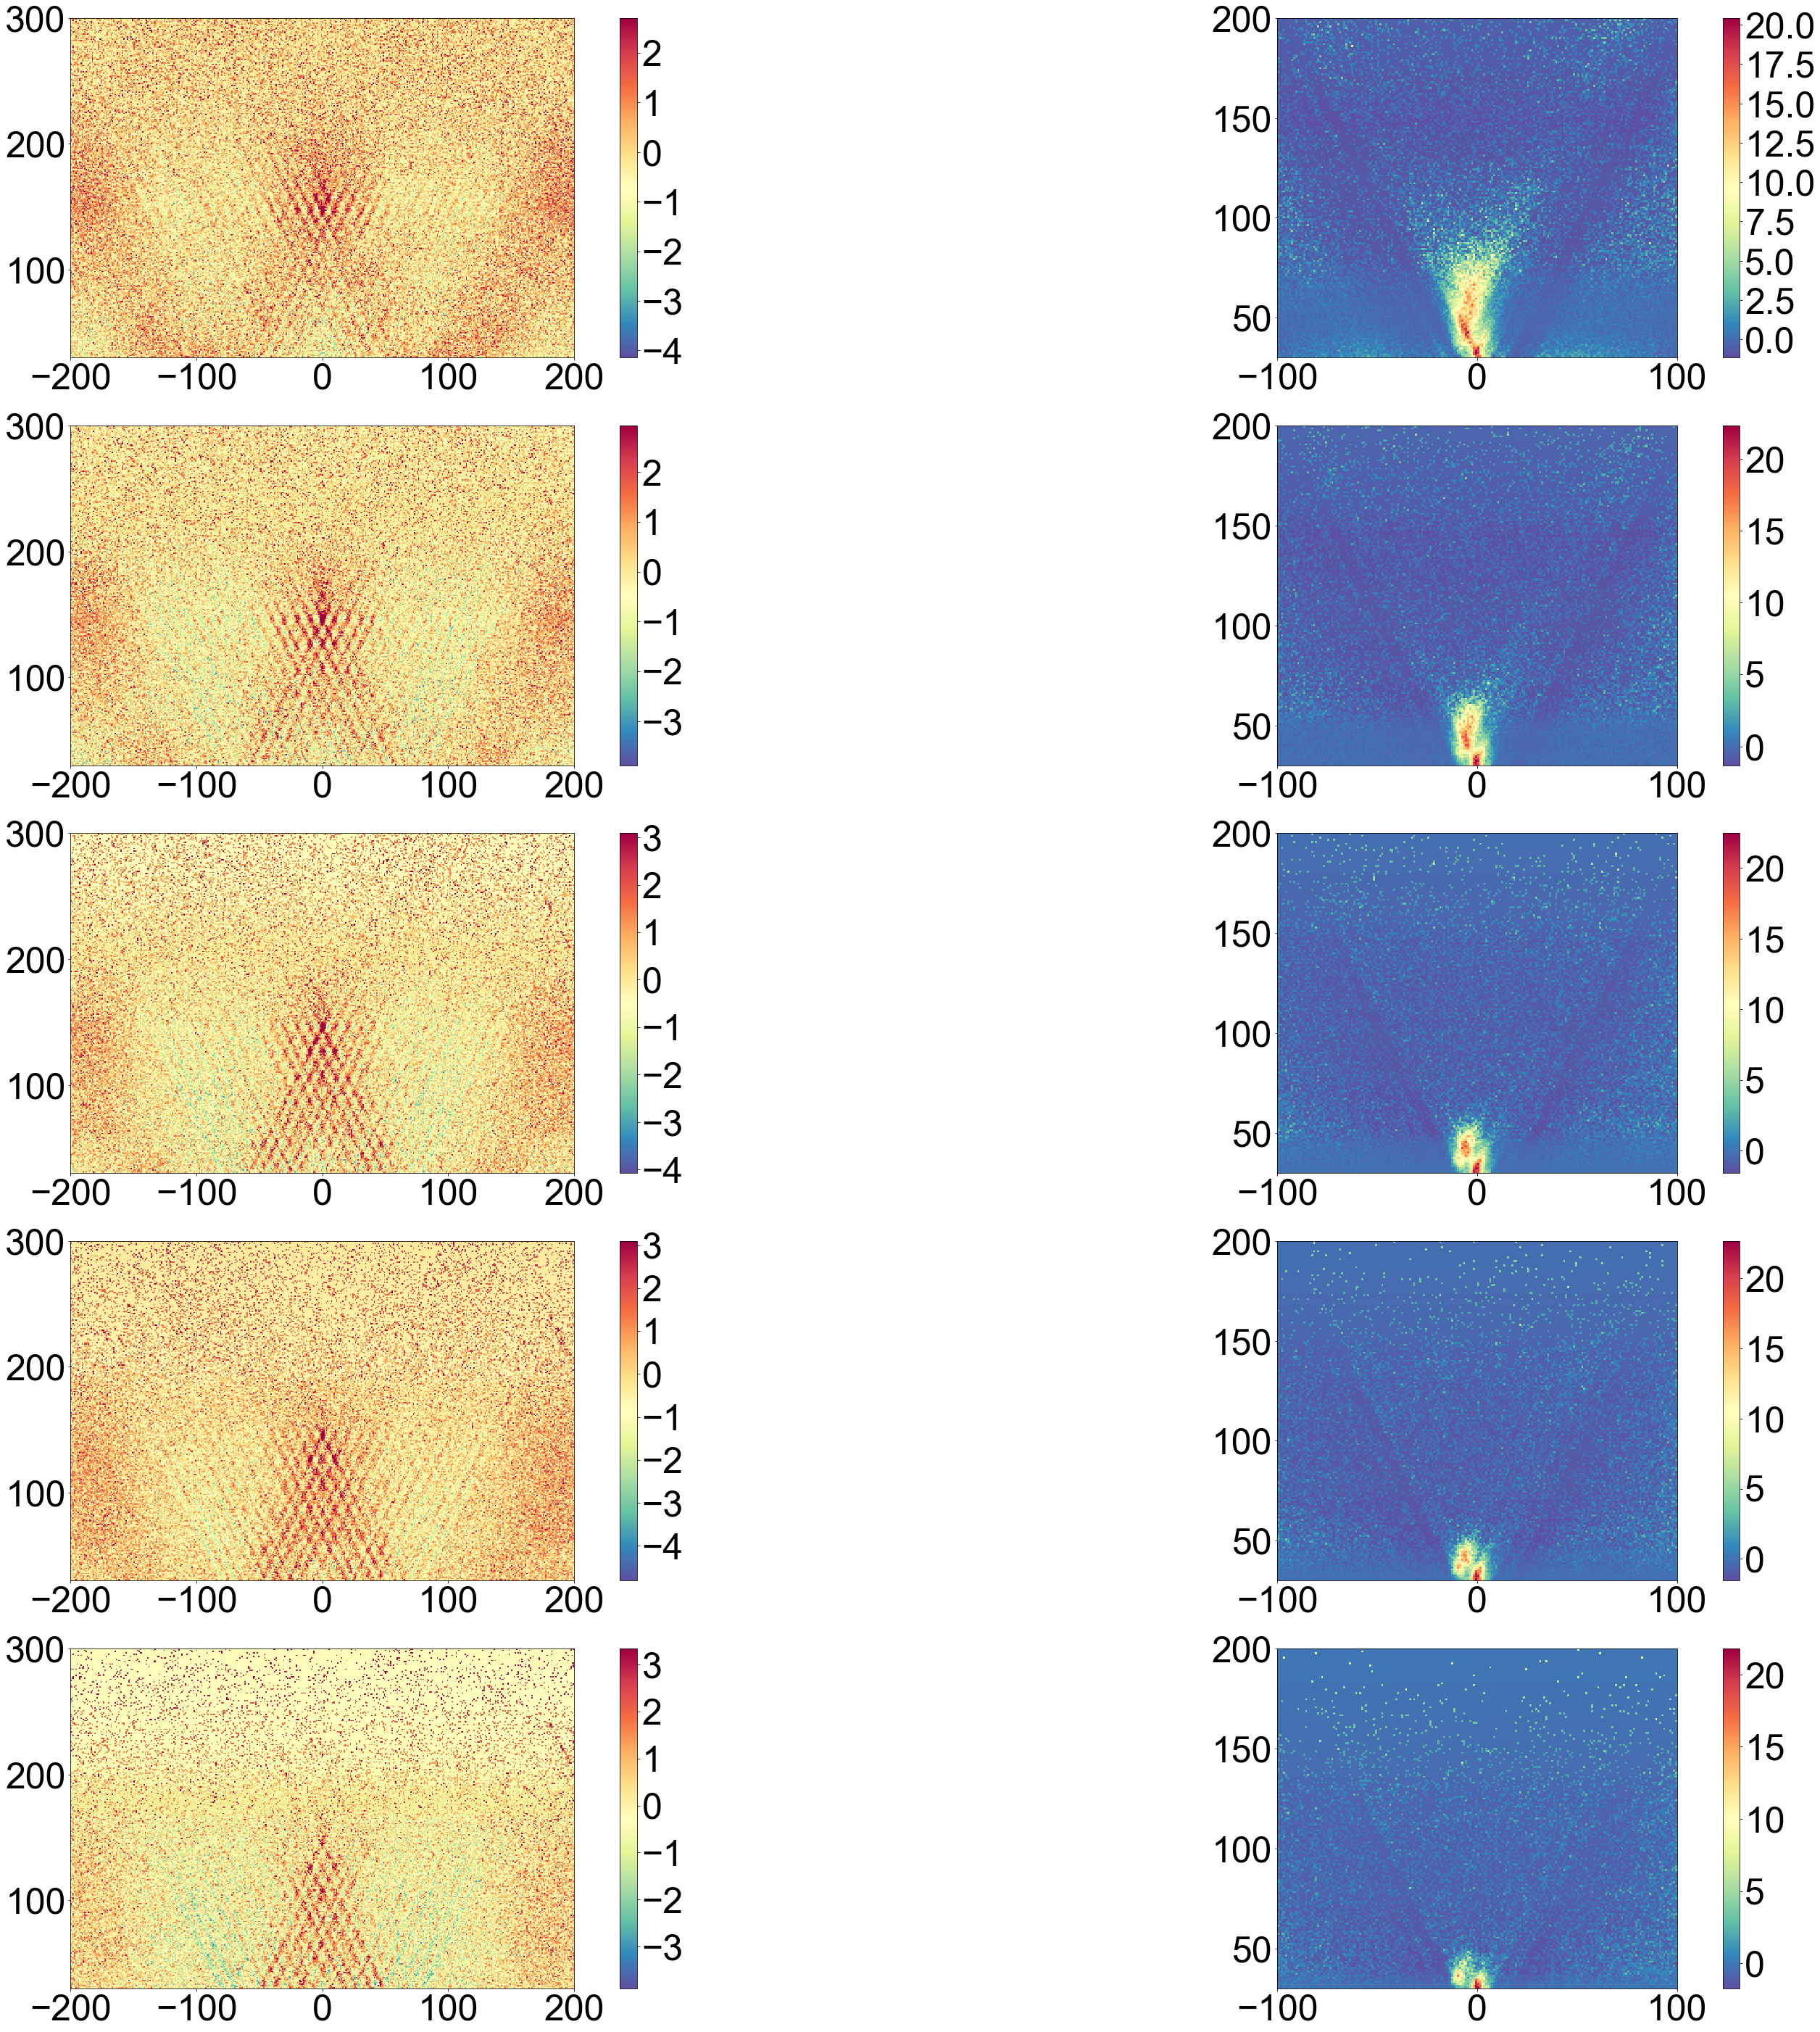

In [82]:
#FIG4A
def visualize_vplot(matrix):
    row_mean = matrix.mean(axis=1)
    row_sd = matrix.std(axis = 1)
    matrix_z = (matrix - row_mean[:,np.newaxis]) / row_sd[:, np.newaxis]
    return matrix_z

def cap_vplot(matrix, percentile):
    new_plot = np.copy(matrix)
    cap = np.percentile(new_plot, percentile)
    new_plot[new_plot > cap] = cap
    print cap
    return new_plot

# ctcf = np.load("Vplot.plus.mid.Male_Ctcf.npy") + np.load("Vplot.minus.mid.Male_Ctcf.npy")
# ctcf_z = visualize_vplot(ctcf)

matrix = np.load("Vplot.plus.mid.1min_Male_Ctcf.npy") + np.load("Vplot.minus.mid.1min_Male_Ctcf.npy")
min1_z_ctcf = visualize_vplot(matrix)[:,::-1]

matrix = np.load("Vplot.plus.mid.2_5min_Male_Ctcf.npy") + np.load("Vplot.minus.mid.2_5min_Male_Ctcf.npy")
min25_z_ctcf = visualize_vplot(matrix)[:,::-1]

matrix = np.load("Vplot.plus.mid.5min_Male_Ctcf.npy") + np.load("Vplot.minus.mid.5min_Male_Ctcf.npy")
min5_z_ctcf = visualize_vplot(matrix)[:,::-1]

matrix = np.load("Vplot.plus.mid.10min_Male_Ctcf.npy") + np.load("Vplot.minus.mid.10min_Male_Ctcf.npy")
min10_z_ctcf = visualize_vplot(matrix)[:,::-1]

matrix = np.load("Vplot.plus.mid.20min_Male_Ctcf.npy") + np.load("Vplot.minus.mid.20min_Male_Ctcf.npy")
min20_z_ctcf = visualize_vplot(matrix)[:,::-1]

matrix = np.load("Vplot.plus.mid.1min_MNase_chr12_dyad.npy") + np.load("Vplot.minus.mid.1min_MNase_chr12_dyad.npy")
min1_z_nuc = visualize_vplot(matrix)


matrix = np.load("Vplot.plus.mid.2_5min_MNase_chr12_dyad.npy") + np.load("Vplot.minus.mid.2_5min_MNase_chr12_dyad.npy")
min25_z_nuc = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.5min_MNase_chr12_dyad.npy") + np.load("Vplot.minus.mid.5min_MNase_chr12_dyad.npy")
min5_z_nuc = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.10min_MNase_chr12_dyad.npy") + np.load("Vplot.minus.mid.10min_MNase_chr12_dyad.npy")
min10_z_nuc = visualize_vplot(matrix)

matrix = np.load("Vplot.plus.mid.20min_MNase_chr12_dyad.npy") + np.load("Vplot.minus.mid.20min_MNase_chr12_dyad.npy")
min20_z_nuc = visualize_vplot(matrix)


plt.figure(figsize=(50,50))
subplot(522)
imshow(min1_z_ctcf[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(524)
imshow(min25_z_ctcf[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(526)
imshow(min5_z_ctcf[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(528)
imshow(min10_z_ctcf[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(5,2,10)
imshow(min20_z_ctcf[100:,900:1100], interpolation="none", extent=[-100,100,30,200], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(521)
imshow(cap_vplot(min1_z_nuc[:,800:1200], 99), interpolation="none", extent=[-200,200,30,300], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(523)
imshow(cap_vplot(min25_z_nuc[:,800:1200], 99), interpolation="none", extent=[-200,200,30,300], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(525)
imshow(cap_vplot(min5_z_nuc[:,800:1200], 99), interpolation="none", extent=[-200,200,30,300], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(527)
imshow(cap_vplot(min10_z_nuc[:,800:1200], 99), interpolation="none", extent=[-200,200,30,300], cmap=cm.Spectral_r)
colorbar(fraction=0.1)
subplot(529)
imshow(cap_vplot(min20_z_nuc[:,800:1200], 99), interpolation="none", extent=[-200,200,30,300], cmap=cm.Spectral_r)
colorbar(fraction=0.1)


plt.savefig("/Users/vramani/Dropbox/Fig6.pdf")
plt.show()

In [21]:
#This is a potential supp figure about bivalent domains (defined by bedtools intersect of polycomb
#and h3k4me3 overlap / intersect -v)

#This is the code to generate FIG2A
def vectorize_lengths(fhi):
    vecs = Counter()
    vec = []
    for line in fhi:
        split = line.split()
        bp = int(split[0])
        cnt = float(split[1])
        vecs[bp] = cnt
    for i in range(30,300):
        vec.append(vecs[i] / float(sum(vecs.values())))
    return np.array(vec)

def fractionate(array):
    tot = np.sum(array,axis=0)
    tot = tot.astype(float) / float(np.sum(tot))
    return tot



matrix = 0
bg_length = open("Male.mm10.sorted.deduped.bam.lengths")

male_h3k27me3 = open("Male.mm10.sorted.deduped.bam.H3K27me3.length")
male_h3k9me3 = open("Male.mm10.sorted.deduped.bam.H3K9me3.length")

polycomb = vectorize_lengths(male_h3k27me3)[:170] / fracs[:170]
constitutive = vectorize_lengths(male_h3k9me3)[:170] / fracs[:170]

male_bivalent = fractionate(np.load("FLFE.Male_Bivalent.npy"))
male_notbivalent = fractionate(np.load("FLFE.Male_Not_Bivalent.npy"))

bivalent = male_bivalent[:170] / fracs[:170]
not_bivalent = male_notbivalent[:170] / fracs[:170]

# plt.plot(range(len(test1)), np.log(test1), c="red")
# plt.plot(range(len(test1)), np.log(test2), c="blue")
# plt.plot(range(len(test1)), np.log(test0), c="green")
# plt.show()

ggtxt = open("Bivalent_Supp_Fig.txt", 'w')

for i in range(len(test1)):
    print >> ggtxt, "%s\t%s\t%s" % (i + 30, polycomb[i], "All H3K27me3 (n = 16,648 peaks)")
    print >> ggtxt, "%s\t%s\t%s" % (i + 30, bivalent[i], "Bivalent H3K27me3 (n = 4,713 peaks)")
    print >> ggtxt, "%s\t%s\t%s" % (i + 30, not_bivalent[i], "Non-Bivalent H3K27me3 (n = 12,035 peaks)")
    print >> ggtxt, "%s\t%s\t%s" % (i + 30, constitutive[i], "H3K9me3 (n = 45,310 peaks)")

ggtxt.close()

In [16]:
test = ["30.50","51.70","71.90","91.110","111.140","141.190"]
ctcf = np.load("Hmaps_Male_Ctcf.npz")
short = ctcf['30.39'] + ctcf['40.49'] + ctcf['50.59']

plot_longer = pd.DataFrame(np.nan_to_num(normalize(short)))
rolling_longer = np.nan_to_num(plot_longer.rolling(window=10,center=True,axis=1).mean().values)

coords = []
for i in rolling_longer:
#   print i
 #   print rolling_longer[i]
#    width = np.sum(i[450:550])
    peak_intensity = np.average(i[950:1050], axis = 0)
    coords.append(peak_intensity)

chips = []
fimos = []
fhi = open("/Users/vijayramani/CTCF_mES.sites.flat.sorted.distances.filtered.bed.ChIPintensity")
for line in fhi:
    split = line.split()
    fimo = float(split[4])
    fimos.append(fimo)
    chip = float(split[5])
    chips.append(chip)




/Users/vijayramani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in divide


In [4]:
test = ["30.50","51.70","71.90","91.110","111.140","141.190"]
ctcf = np.load("Hmaps_Male_Rest.npz")
short = ctcf['30.39'] + ctcf['40.49'] + ctcf['50.59']

plot_longer = pd.DataFrame(np.nan_to_num(normalize(short)))
rolling_longer = np.nan_to_num(plot_longer.rolling(window=10,center=True,axis=1).mean().values)

coords = []
for i in rolling_longer:
#   print i
 #   print rolling_longer[i]
#    width = np.sum(i[450:550])
    peak_intensity = np.average(i[950:1050], axis = 0)
    coords.append(peak_intensity)

chips = []
fimos = []
fhi = open("/Users/vijayramani/Dropbox/REST_mES.sites.flat.sorted.distances.filtered.bed.wchip")
for line in fhi:
    split = line.split()
    fimo = float(split[4])
    fimos.append(fimo)
    chip = float(split[10])
    chips.append(chip)




1144
1144
1144


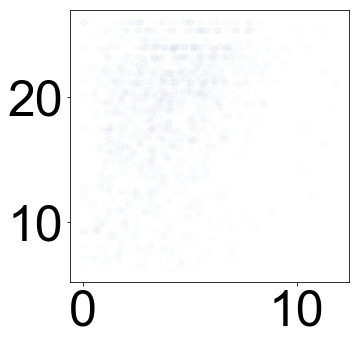

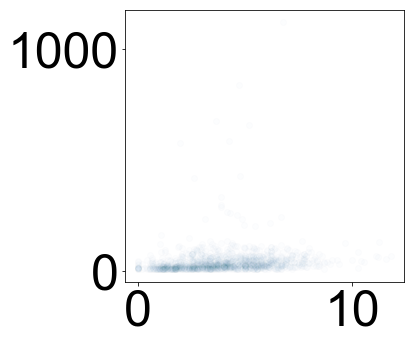

In [5]:
print len(fimos)
print len(chips)
print len(coords)

plt.figure(figsize=(5,5))
plt.scatter(coords,fimos,alpha=0.01)
plt.show()
plt.figure(figsize=(5,5))
plt.scatter(coords,chips,alpha=0.01)
plt.show()

fho = open("rest_correlation_for_review.txt", 'w')
for i in range(len(fimos)):
    print >> fho, "%s\t%s\t%s" % (fimos[i],chips[i],coords[i])
fho.close()
